In [81]:

import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import scipy as sc
from scipy.stats import moyal
import os
import pickle
import glob
%matplotlib inline
np.seterr(divide = 'ignore') 


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [83]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)
def getValues(files,skip,nFiles=-1,findex=0,single=False,prnt=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    next(f)
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                print(f"Analyzing Following Files ---> {k}")
                break

    return theone

def Histogram(data,xlabel,ylabel,title,figsize=(12,8),dpi=300,bins=3):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.hist(data,bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)

def getArea(pmt,xlow,xhigh,minpulse=9999,gain=0,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    print(f" data = {datamin},value --> {datamin>=minpulse}")
    if(datamin>=minpulse and minpulse!=9999): 
        return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    area=abs(np.trapz(DataNoOffset[DataMask],dx=dt))
    if(gain):
        PE=NumofPE(area,50,gain,1.62e-19)
        
    
    return area,PE

def MultiAreaPE(data,xlow,xhigh,minpulse,g,p=False):
    area=np.array([])
    PE=np.array([])
    for key in data:
        result=getArea(data[key],xlow,xhigh,minpulse=minpulse,gain=g,p=p)
        if(result!=-1):
            area=np.append(area,result[0])
            PE=np.append(PE,result[1])
    values=np.array([area,PE])
    
    return values
def ListofFiles(path):
    Ch1filelist=[]
    Ch2filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
            #append the file name to the list
            if(file[:2]=="C2"):
                Ch2filelist.append(os.path.join(root,file))
            elif(file[:2]=="C1"):
                Ch1filelist.append(os.path.join(root,file))
    return Ch1filelist,Ch2filelist
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            if(len(y)==0):
                s=str(x[i]) +"\n"
            else:
                s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)
def LogNormFit(data,title):
    fig, ax = plt.subplots(1, 1)
    plt.title(title+"_logNorm")
    plt.ylabel("Number of Events")
    plt.xlabel("PE")
    dataMask=data>1
    data=data[dataMask]
    x=np.log(data)
    print(min(x))
    print(max(x))
    mean=np.exp(st.mean(x))
    stdev=np.exp(st.stdev(x))
    plt.hist(x,bins=100,density=True,stacked=True)
    plt.show()
    ### Prepare the Fit
    fitting_params_lognormal = sc.stats.lognorm.fit(data, floc=0, scale=mean)
    lognorm_dist_fitted = sc.stats.lognorm(*fitting_params_lognormal)
    lognorm_dist = sc.stats.lognorm(s=stdev, loc=0, scale=mean)
    t=np.linspace(np.min(data),np.max(data),100)
    print(f"Area mean = {mean} stdev = {stdev}")
    plt.figure(figsize=(12,8),dpi=300)
    plt.title(title)
    plt.ylabel("Number of Events")
    plt.xlabel("PE")
    plt.hist(data,bins=100,density=True,stacked=True,label="data")
    plt.plot(t,lognorm_dist_fitted.pdf(t),lw=2,color='r',label="Fit")
    plt.legend()
    plt.show()


def getSimValues(files,weight):
    values={"S1_PHOTOCATHODE":np.array([]),"S2_PHOTOCATHODE":np.array([])}
    for i in files:
        count=0
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values[splitline[0]]=np.append(values[splitline[0]],round(int(splitline[1])/weight))
        f.close()
        
    return values


In [3]:
###### Sim S1 Results  #####
SimPath="/media/ilker/Ilker/CRAB/07_20_2022/S1_counts/*.txt"
S1files = glob.glob(SimPath,recursive=True)
S1=getSimValues(S1files,1)

#Histogram(S2["S1_PHOTOCATHODE"],"PhotoElectrons","# Events","PMT3_S2",bins=50)
PMT1_S1_mean=st.mean(S1["S2_PHOTOCATHODE"])
PMT1_S1_stdev=st.stdev(S1["S2_PHOTOCATHODE"])
PMT3_S1_mean=st.mean(S1["S1_PHOTOCATHODE"])
PMT3_S1_stdev=st.stdev(S1["S1_PHOTOCATHODE"])


In [4]:
IlkersGains=[3.9e6,2.6e6]
NicksGains=[3.4e6,2.2e6]
DrBrandtGains=[2.5e6,3.8e6]

In [5]:
Run1_Ch1=ListofFiles("/media/ilker/Ilker/CRAB/07.08.22/S1")[0]
Run1_Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.08.22/S1")[1]
Path="/media/ilker/Ilker/CRAB/Analysis/Oct5_2022/CRAB/Main/SimAnalysis/"

Analyzing Following Files ---> /media/ilker/Ilker/CRAB/07.08.22/S1/C1s1-bothPMTs00026.csv


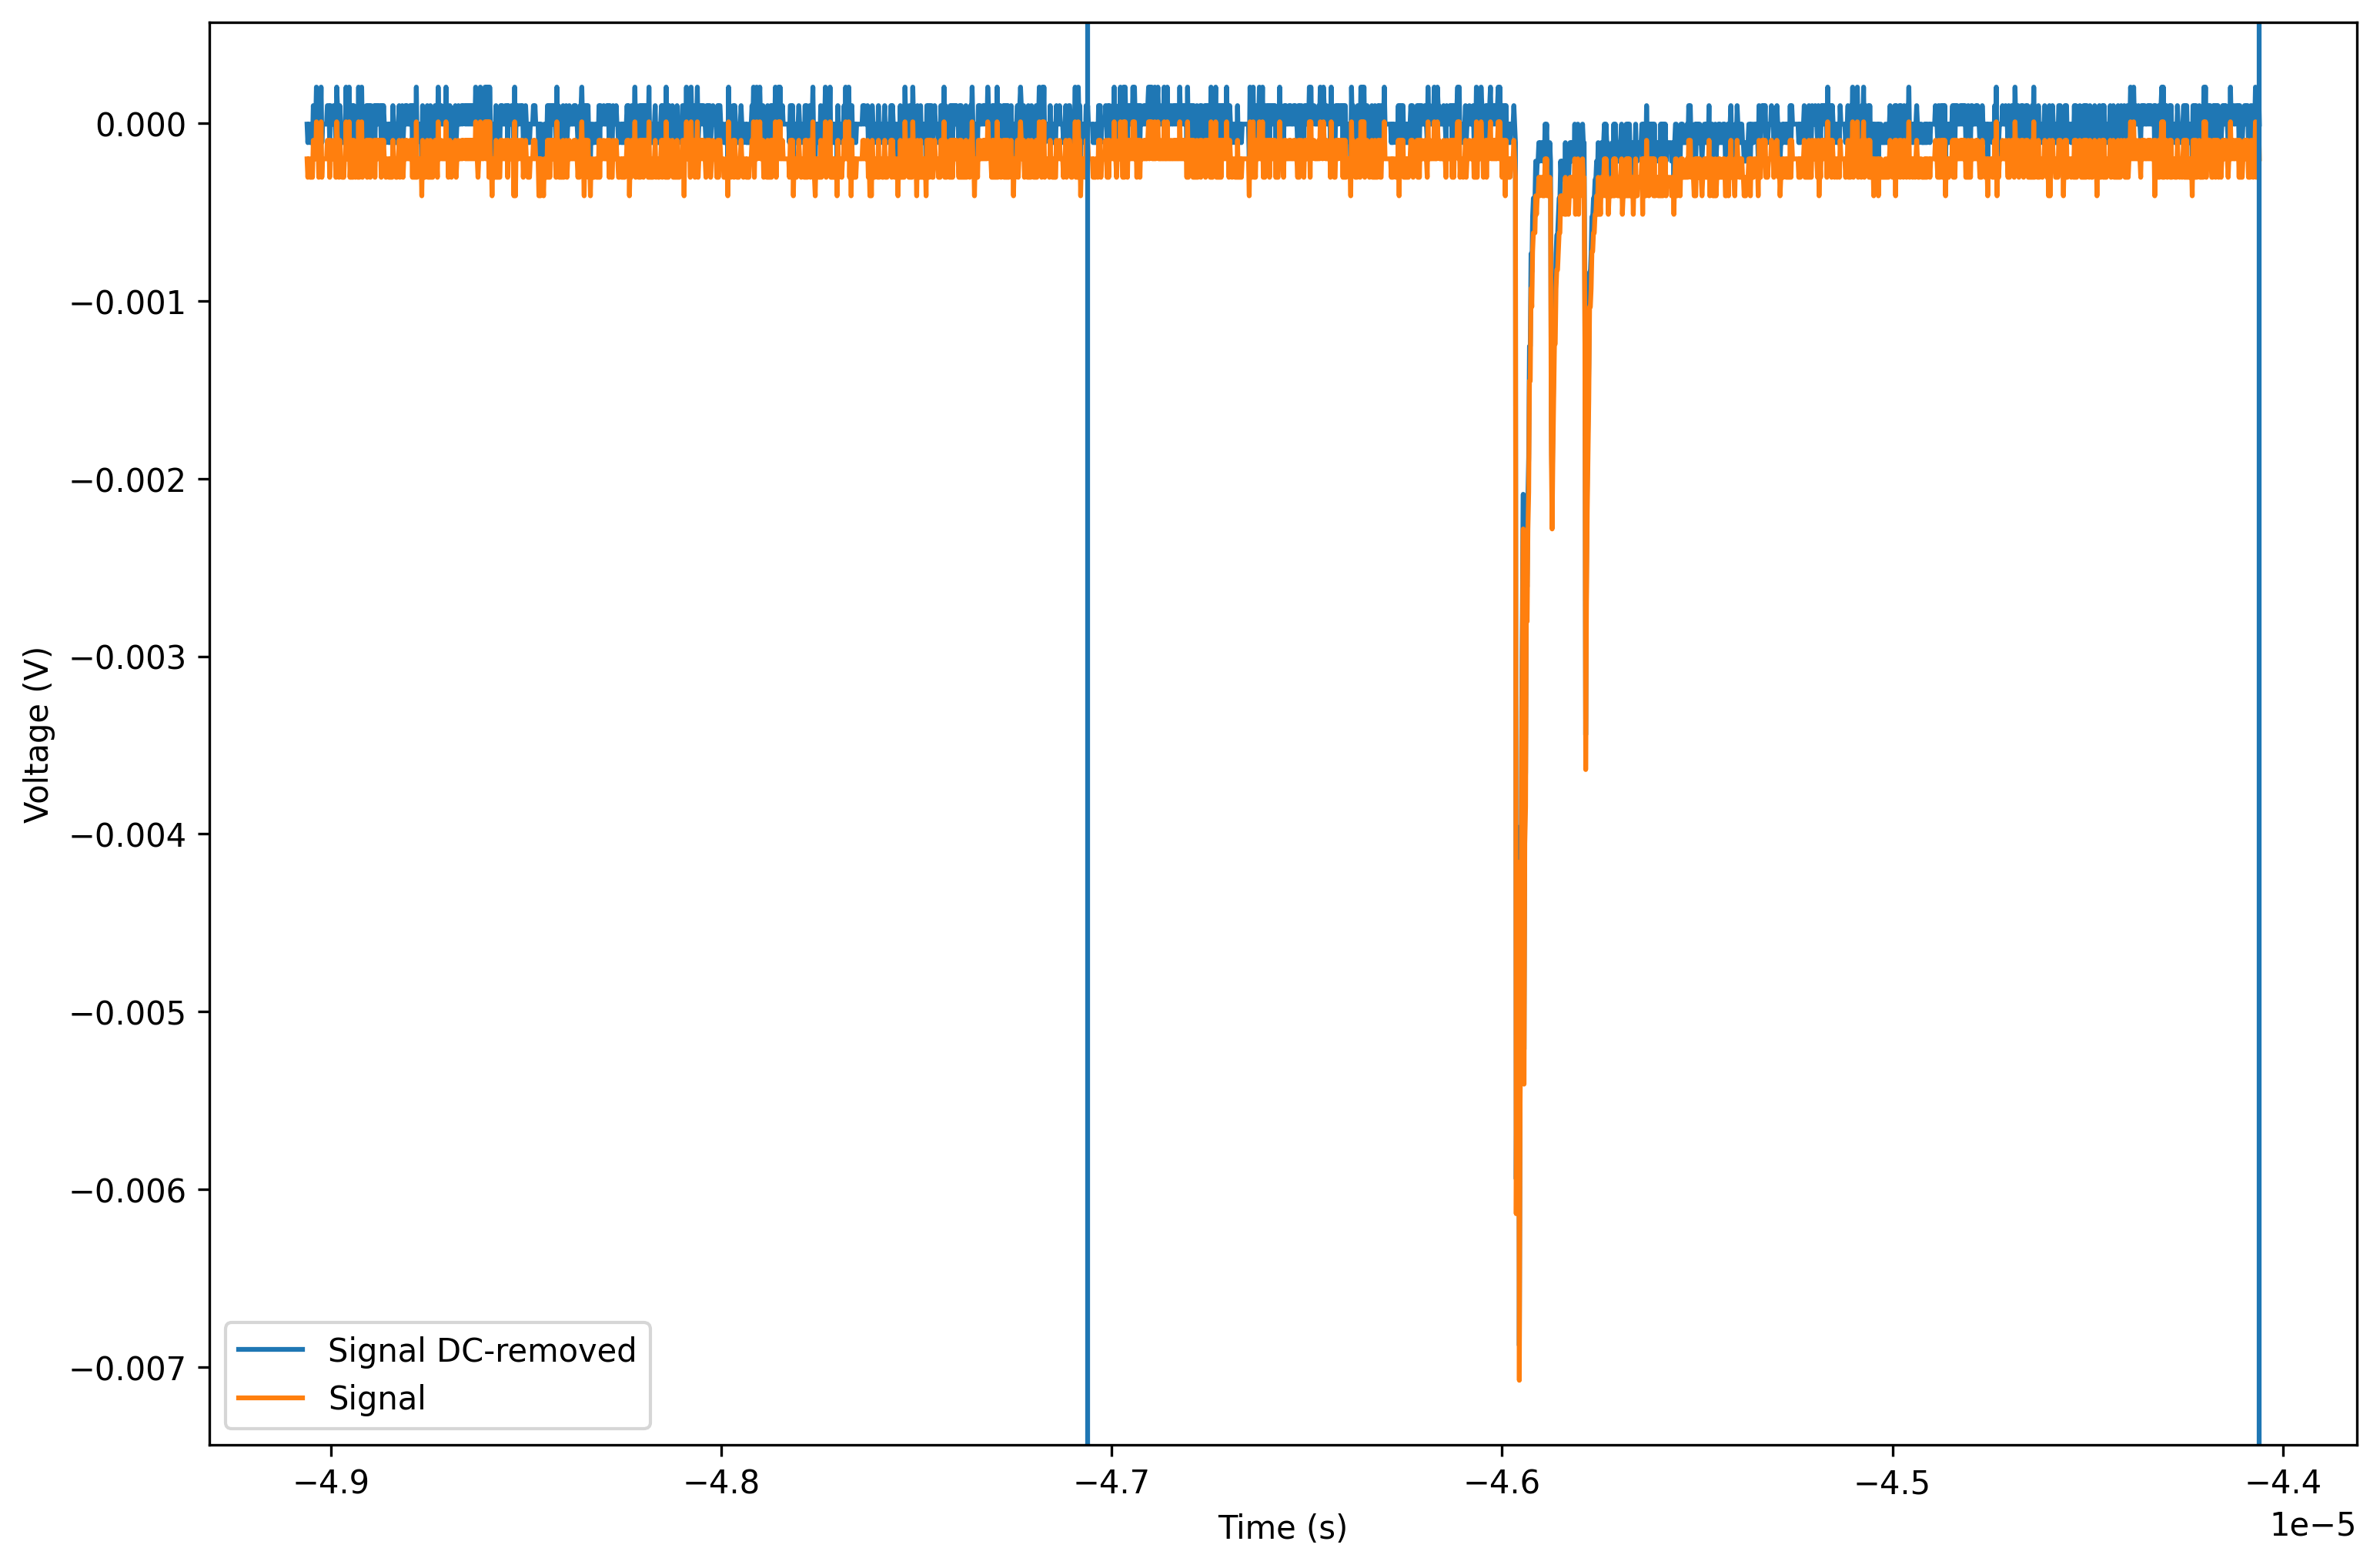

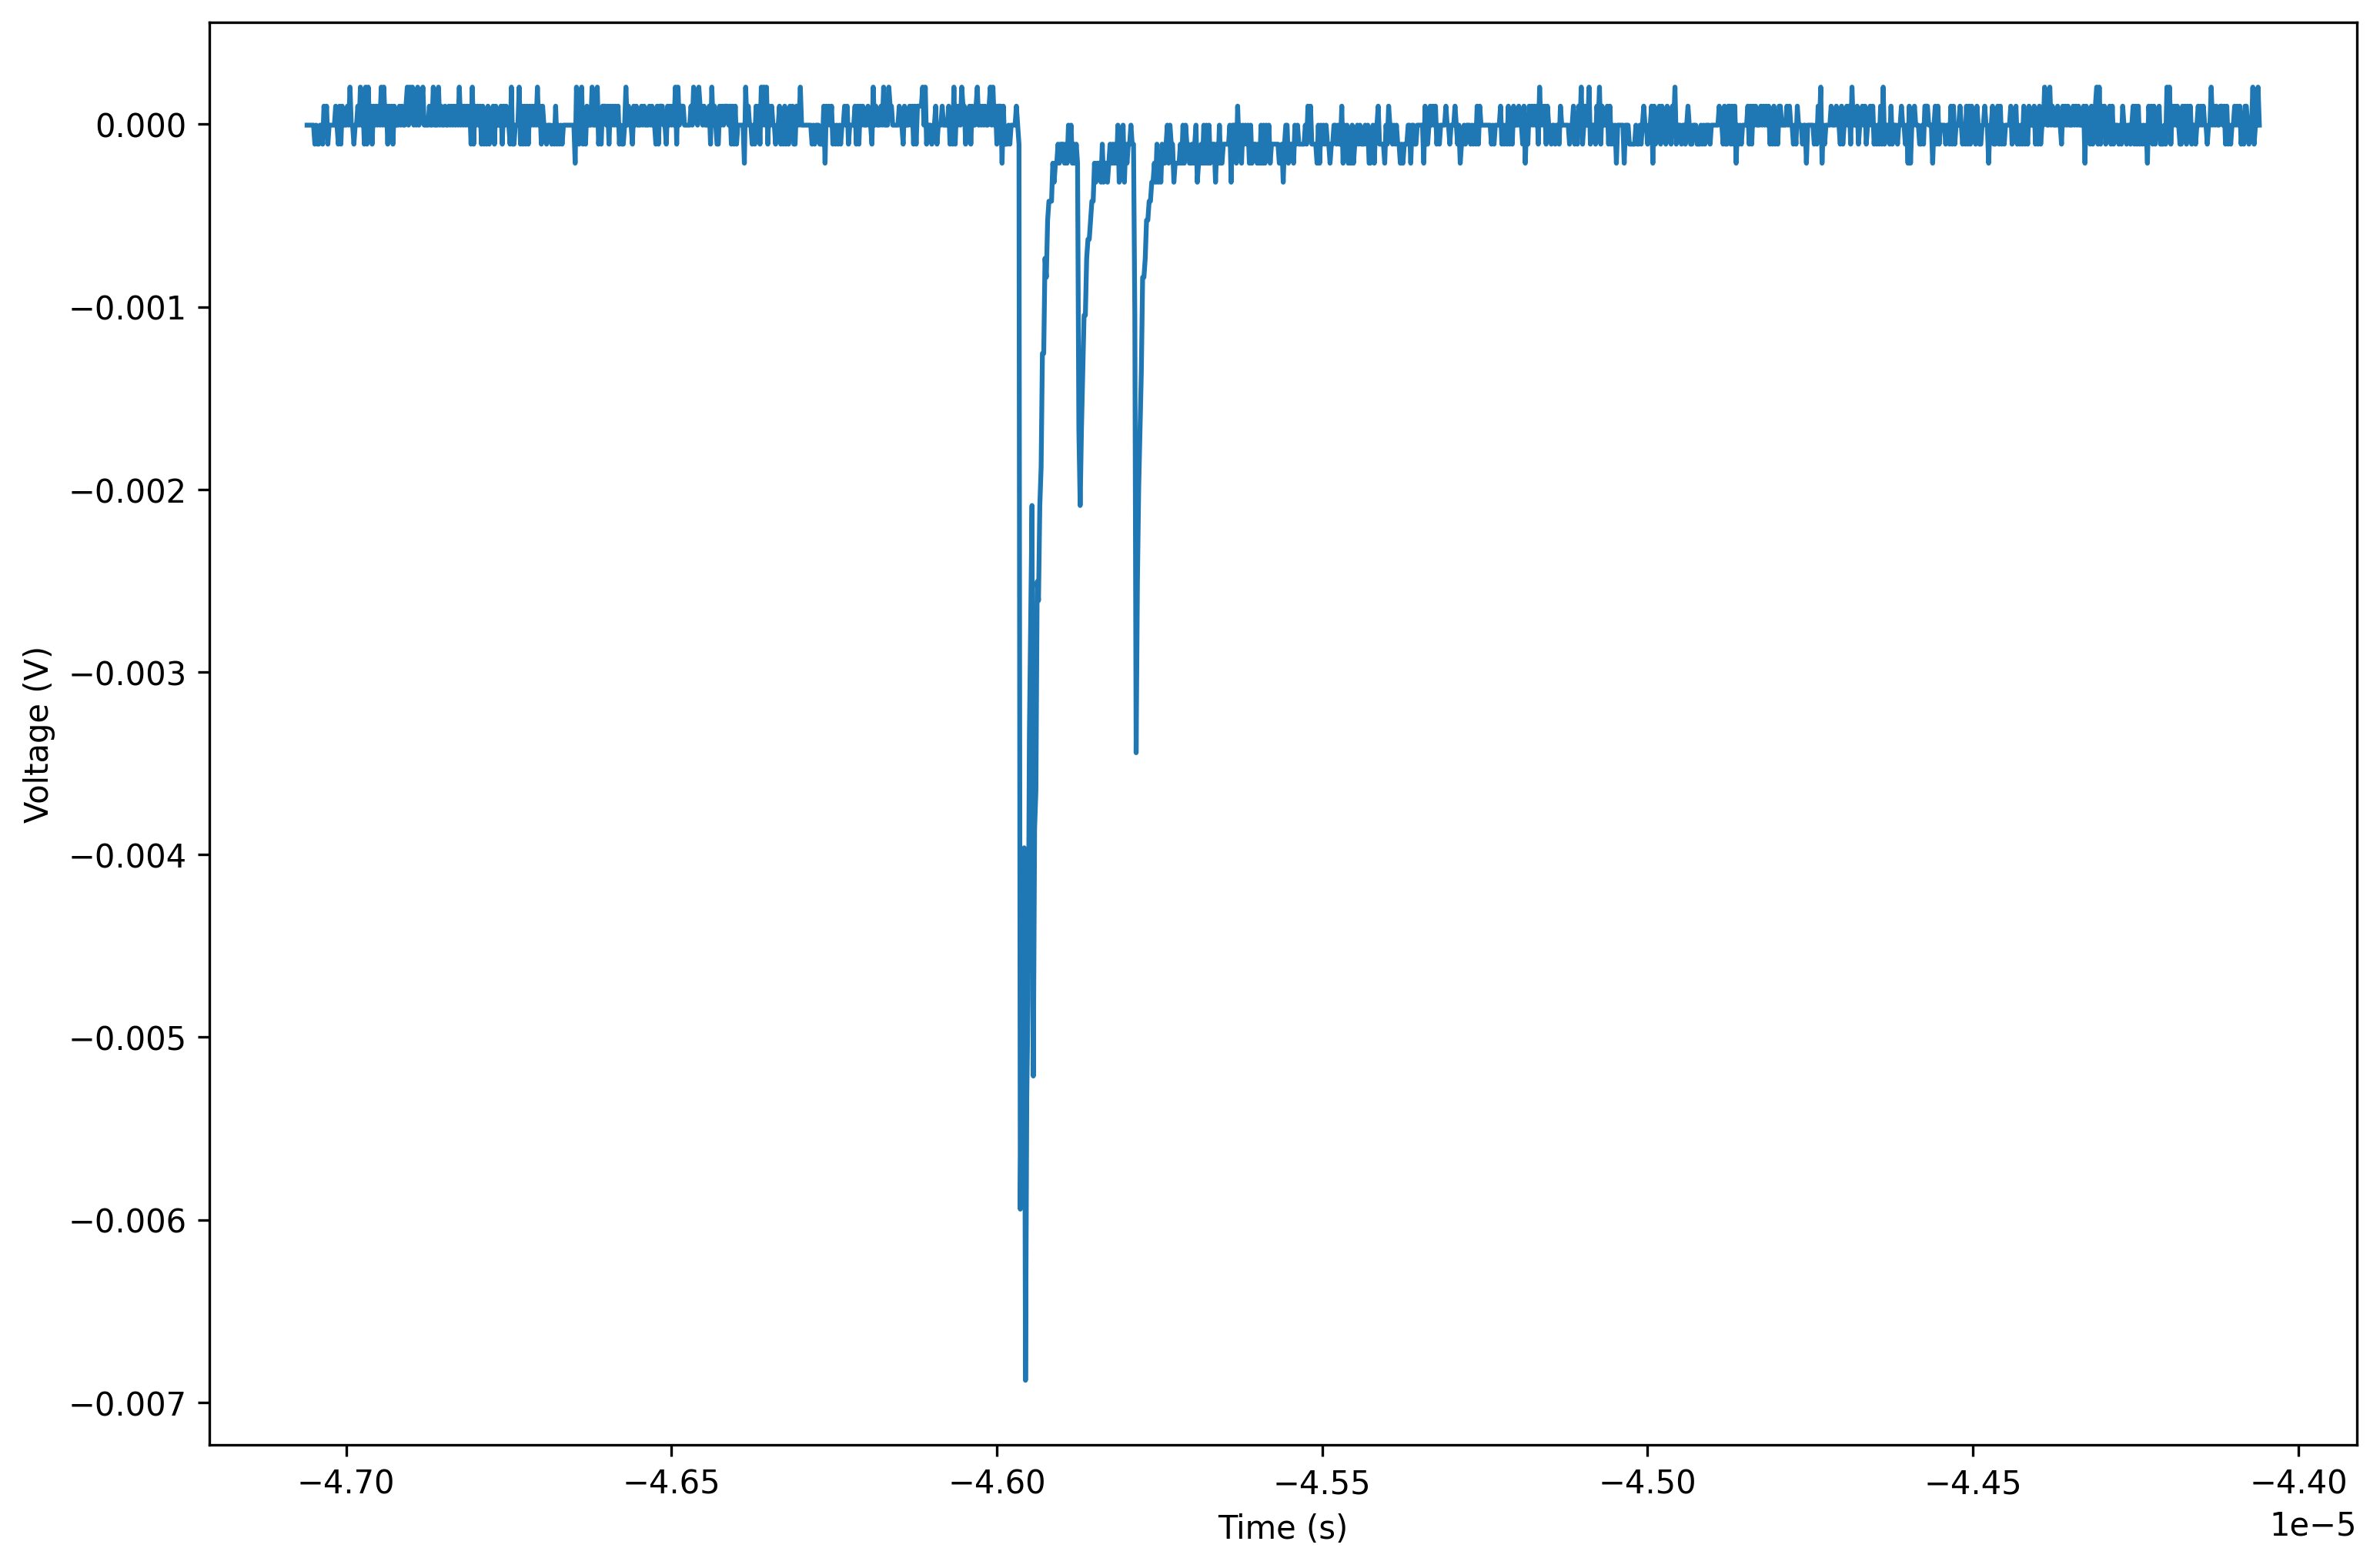

(2.511317761458527e-10, 7.949723841274222)

In [67]:
Run1_Ch1Quick=getValues(Run1_Ch1,5,nFiles=20,single=False,prnt=False)
xmin=min(Run1_Ch1Quick[2]["time"])
xmax=max(Run1_Ch1Quick[2]["time"])

getArea(Run1_Ch1Quick[1],xmin+0.2e-5,xmax,minpulse=-0.0004,gain=IlkersGains[0],p=True)

In [7]:
if(not(os.path.exists(Path+"Run1_Ch1_S1data.p"))): 
    Run1_Ch1data=getValues(Run1_Ch1,5,single=False,prnt=False)
    PickleITDump(Run1_Ch1data,Path+"Run1_Ch1_S1data.p")
else:
    Run1_Ch1data=PickleITRead(Path+"Run1_Ch1_S1data.p")
    
if(not(os.path.exists(Path+"Run1_Ch2_S1data.p"))):
    Run1_Ch2data=getValues(Run1_Ch2,5,single=False,prnt=False)
    PickleITDump(Run1_Ch2data,Path+"Run1_Ch2_S1data.p")
else:
    Run1_Ch2data=PickleITRead(Path+"Run1_Ch2_S1data.p")


In [8]:
#### PMT1 ####
Run1_Ch1AreaPEIlker=MultiAreaPE(Run1_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=IlkersGains[0],p=False)
Run1_Ch1AreaPENick=MultiAreaPE(Run1_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=NicksGains[0],p=False)
Run1_Ch1AreaPEDrBrandt=MultiAreaPE(Run1_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)

### PMT3 ####
Run1_Ch2AreaPEIlker=MultiAreaPE(Run1_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=IlkersGains[0],p=False)
Run1_Ch2AreaPENick=MultiAreaPE(Run1_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=NicksGains[0],p=False)
Run1_Ch2AreaPEDrBrandt=MultiAreaPE(Run1_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)

Day1_PMT1=MultiAreaPE(Run1_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=1,p=False)[0]

Day1_PMT3=MultiAreaPE(Run1_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=1,p=False)[0]

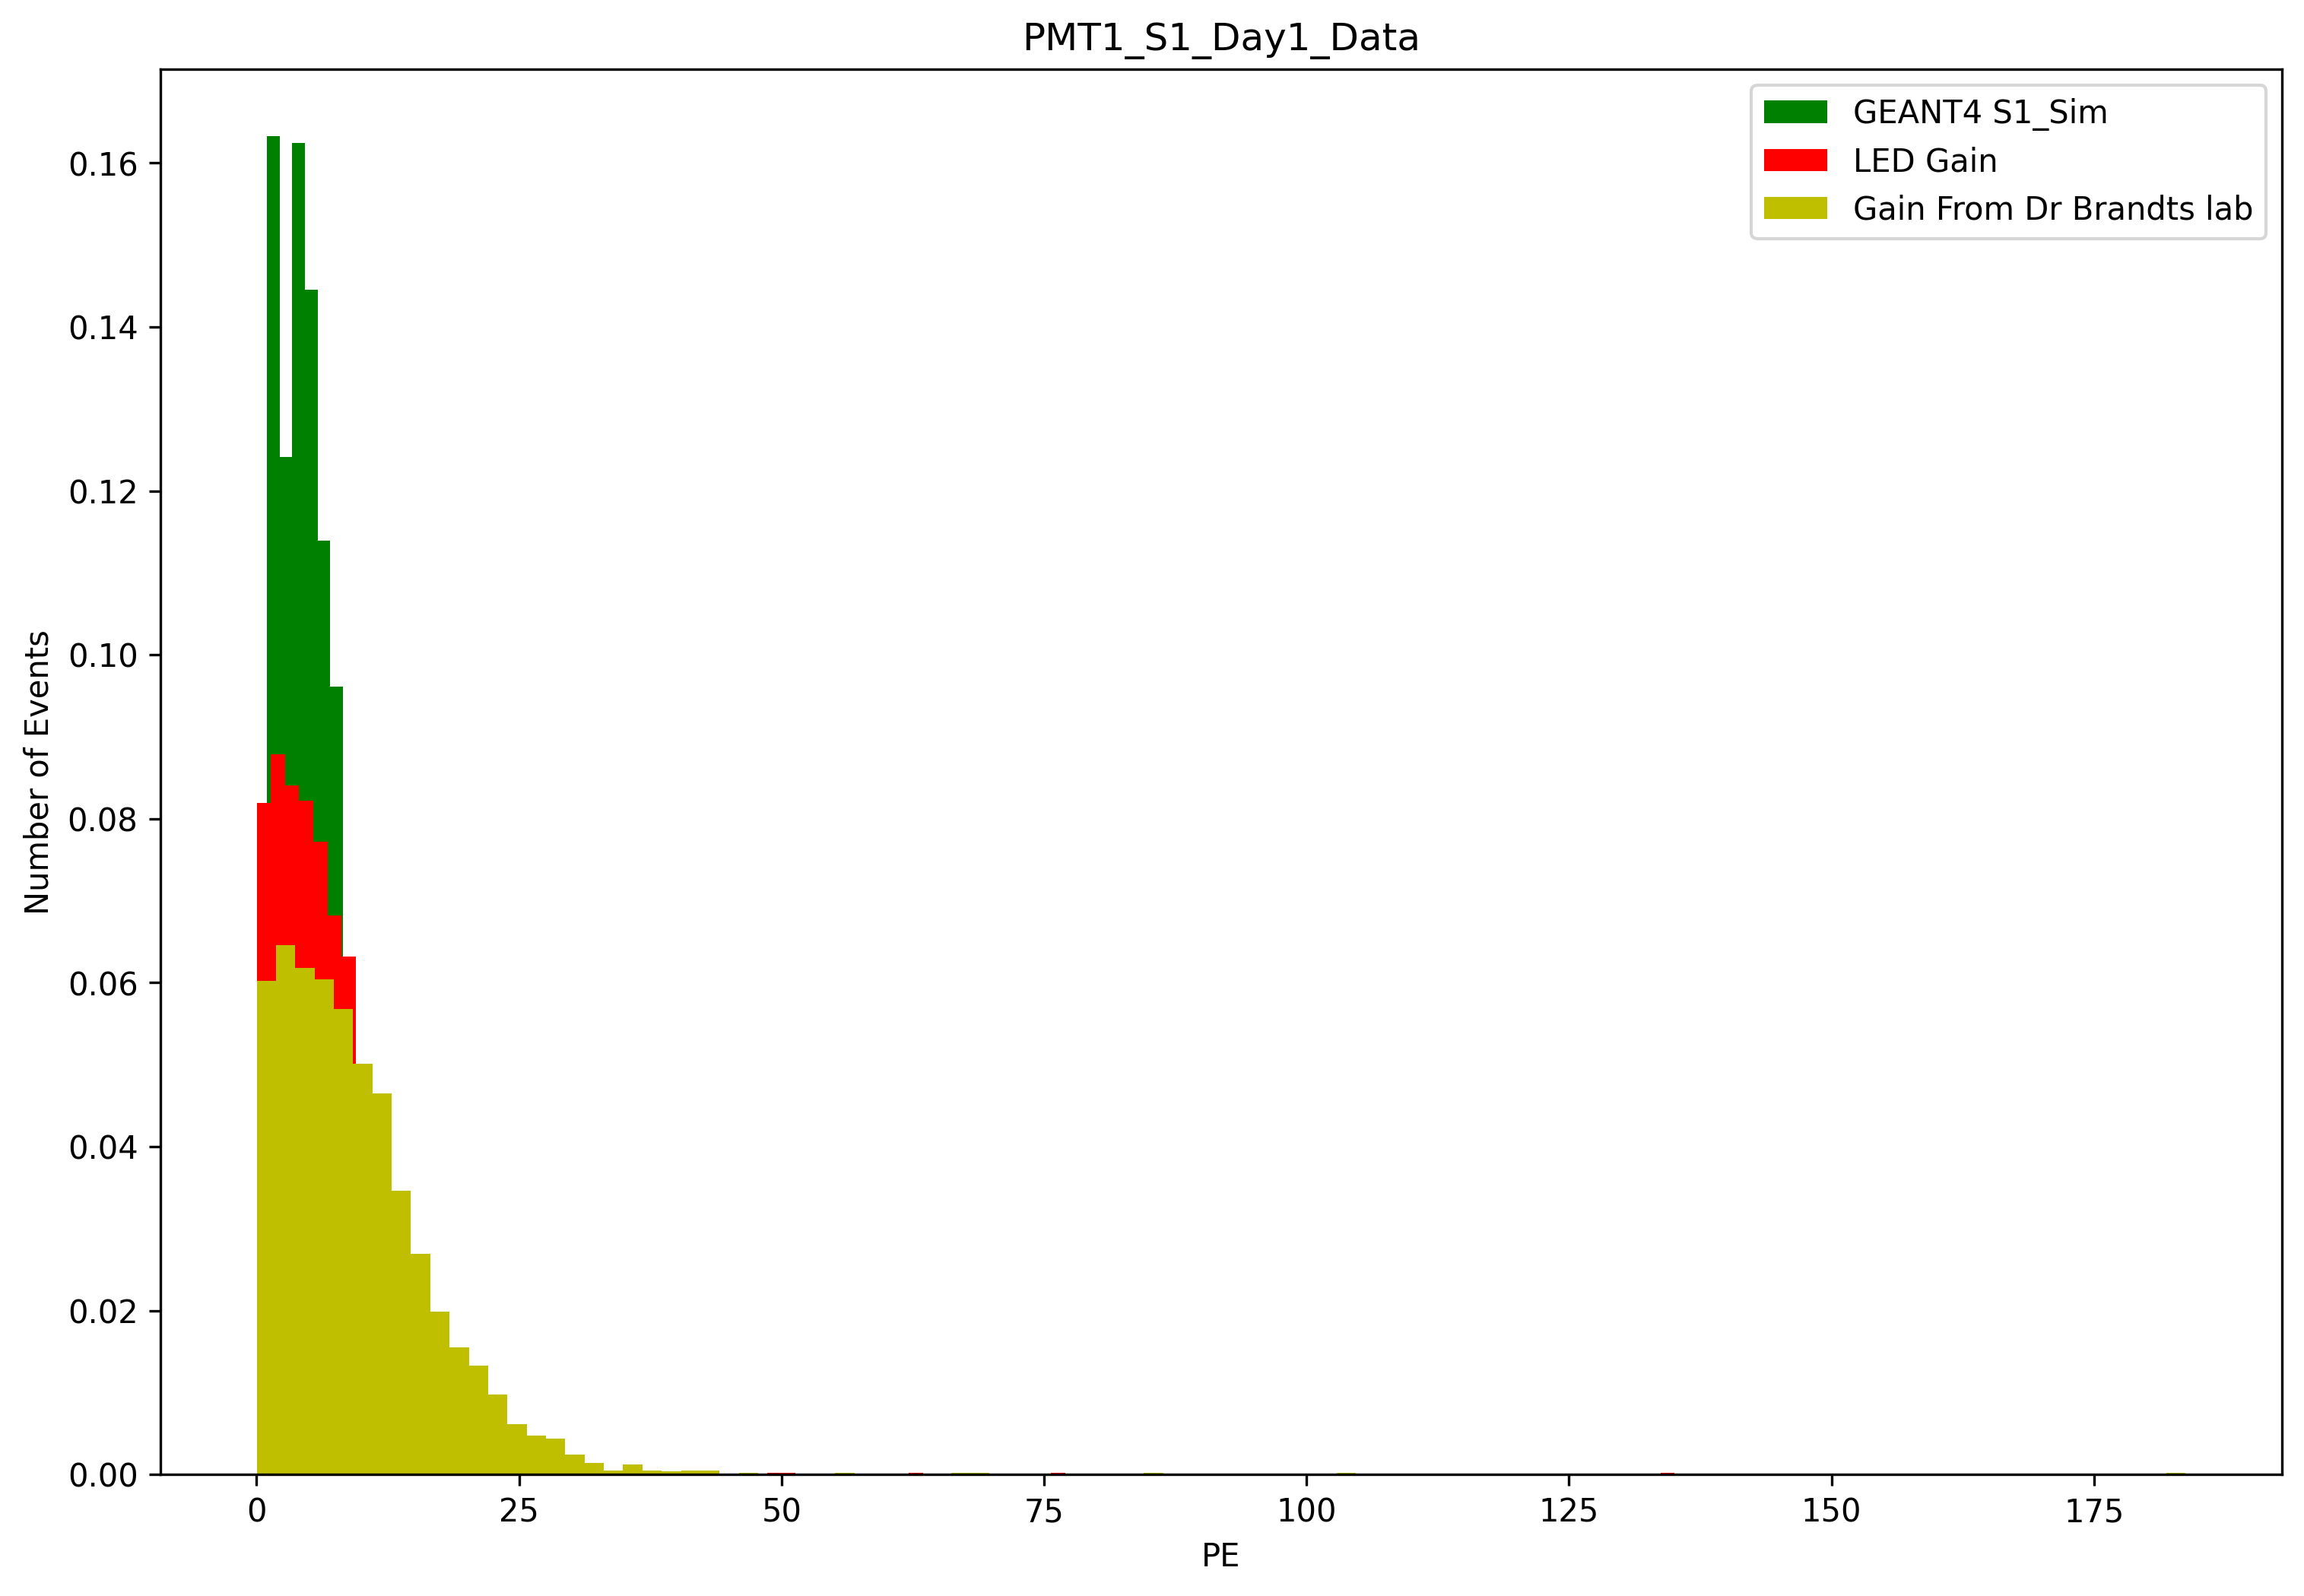

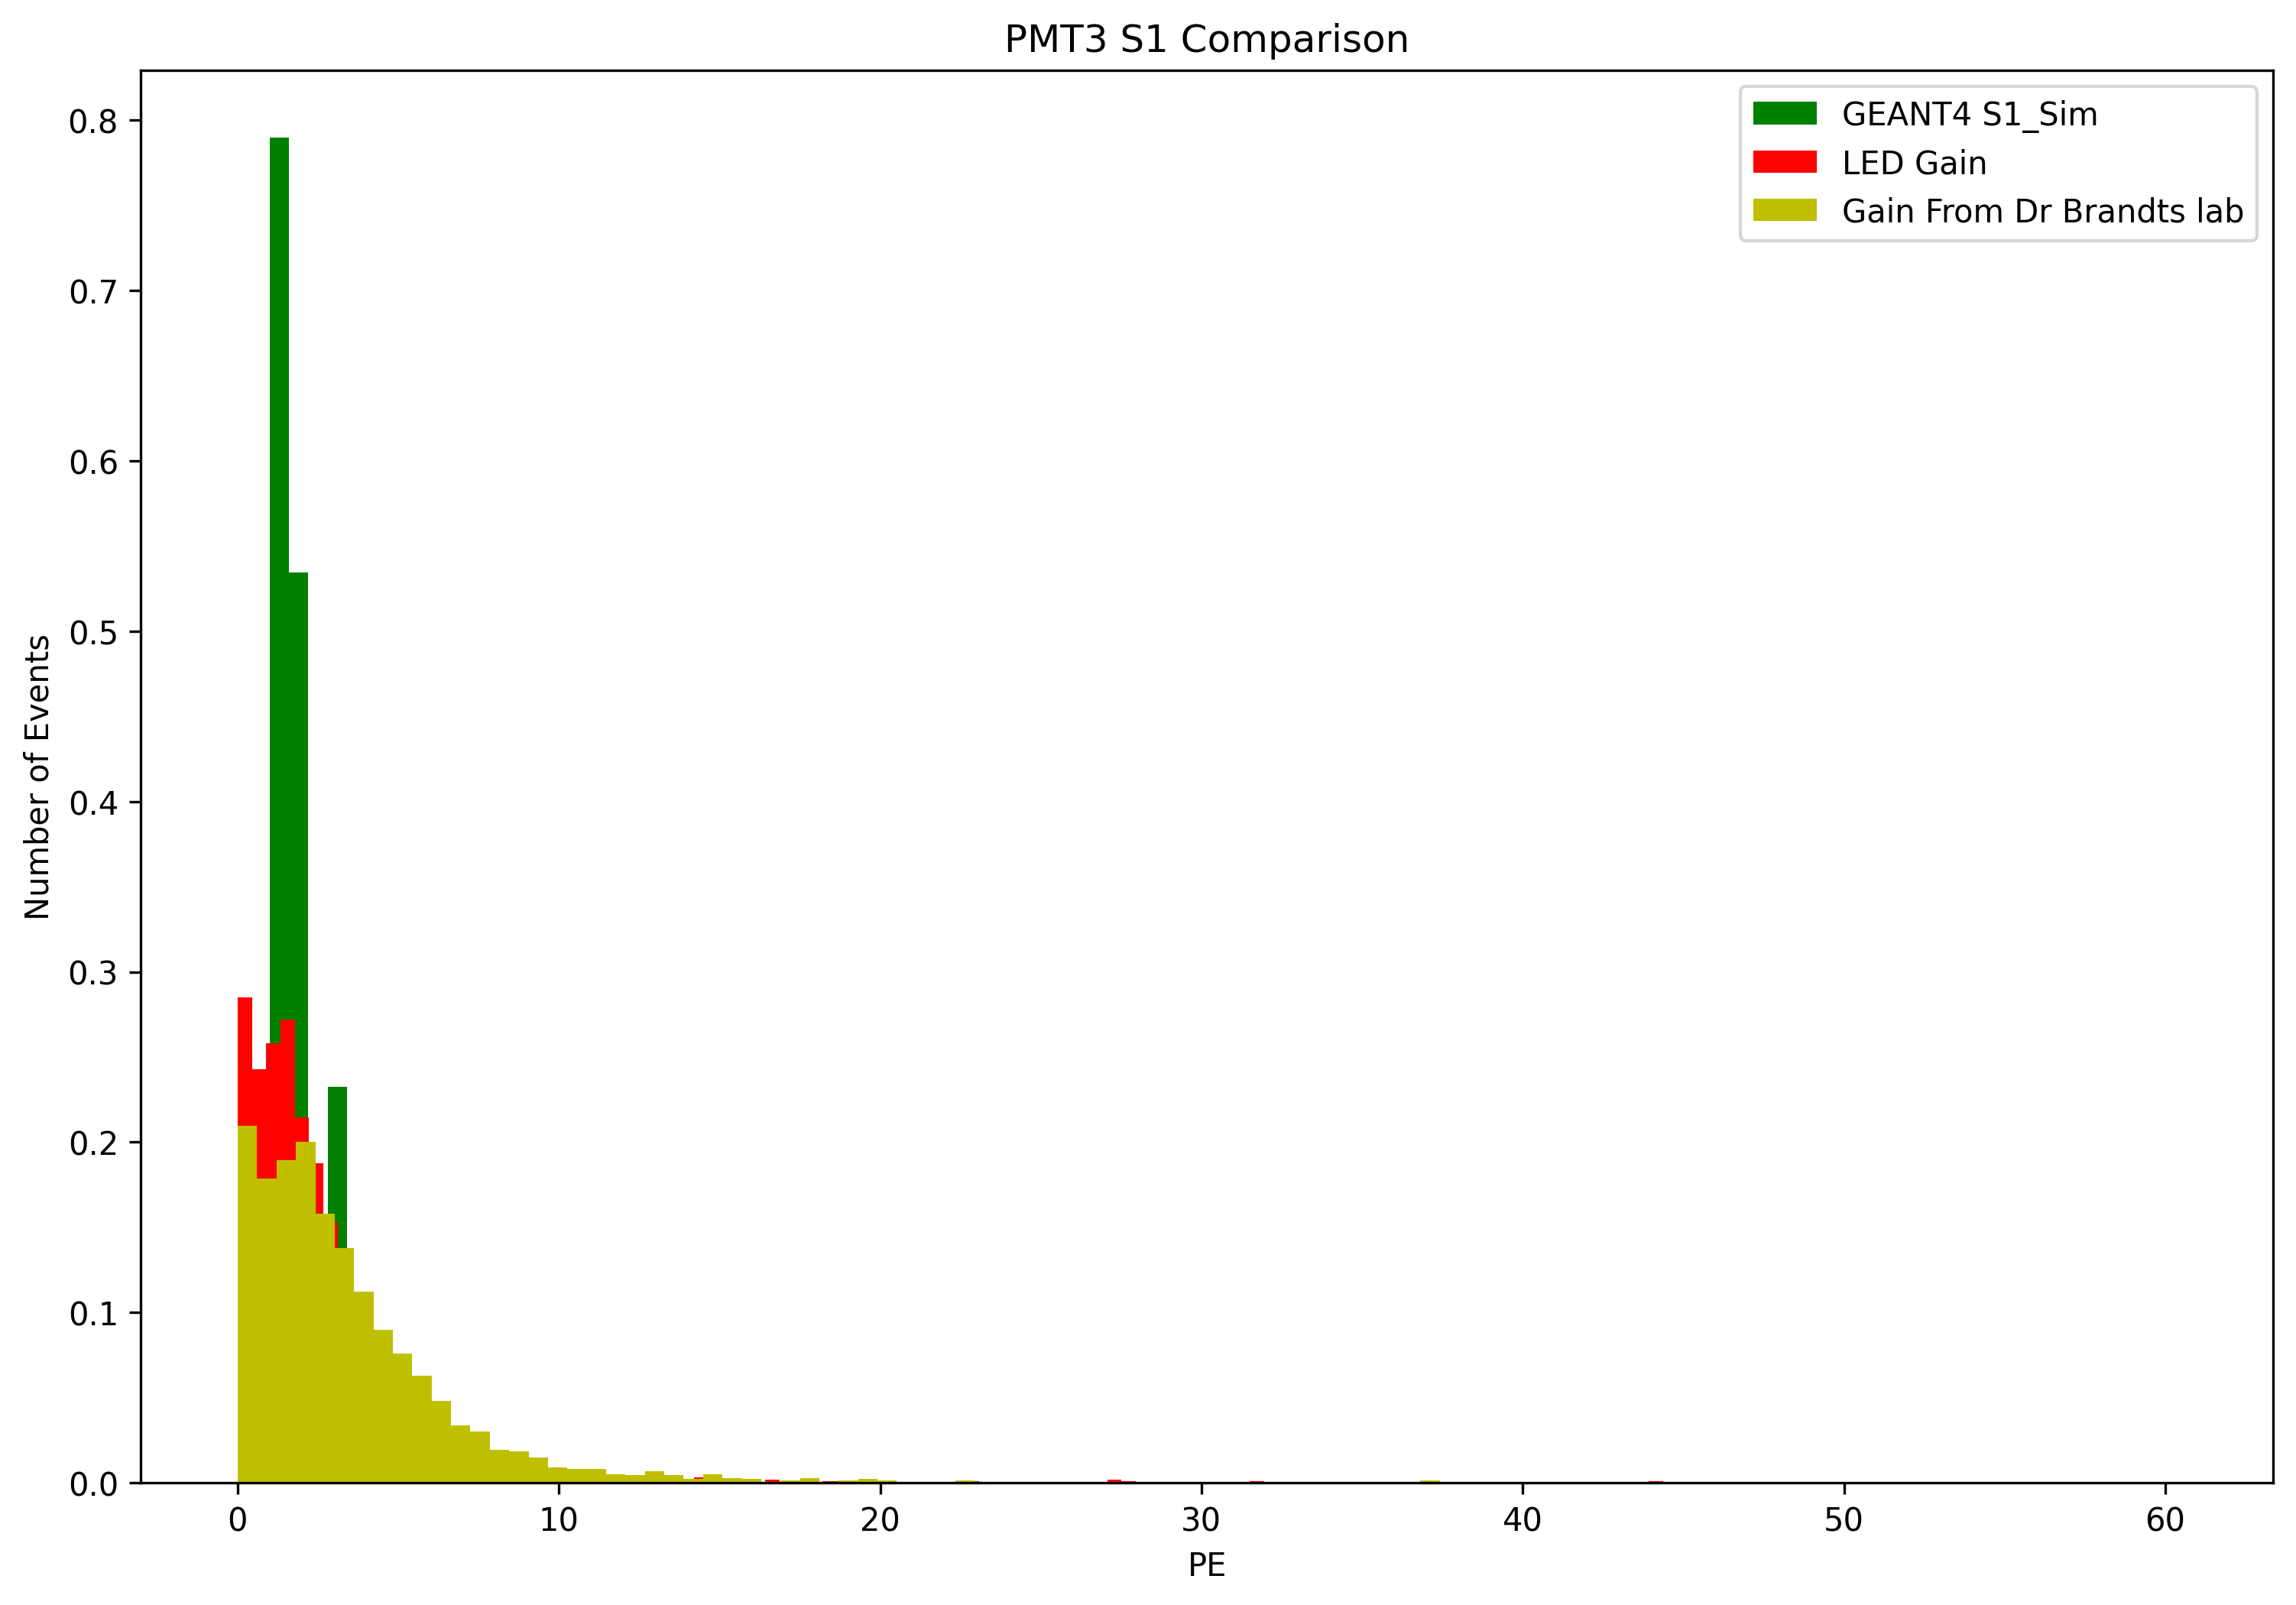

In [9]:
############ S1 Comp #######################
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1_S1_Day1_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(S1["S2_PHOTOCATHODE"],bins=10,density=True,stacked=True,label="GEANT4 S1_Sim",color="g")
#plt.hist(Run1_Ch1AreaPEIlker[1],bins=100,density=True,stacked=True,label="Ilker's Gain",color="b")
plt.hist(Run1_Ch1AreaPENick[1],bins=100,density=True,stacked=True,label="LED Gain",color="r")
plt.hist(Run1_Ch1AreaPEDrBrandt[1],bins=100,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")


plt.legend()
plt.show()




############ S1 Comp #######################
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3 S1 Comparison")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(S1["S1_PHOTOCATHODE"],bins=10,density=True,stacked=True,label="GEANT4 S1_Sim",color="g")
#plt.hist(Run1_Ch2AreaPEIlker[1],bins=100,density=True,stacked=True,label="Ilker's Gain",color="b")
plt.hist(Run1_Ch2AreaPENick[1],bins=100,density=True,stacked=True,label="LED Gain",color="r")
plt.hist(Run1_Ch2AreaPEDrBrandt[1],bins=100,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")


plt.legend()
plt.show()

0.003081176198671788
5.213268214246836


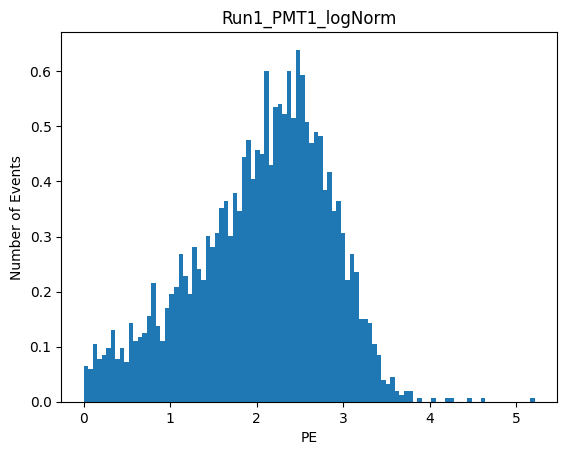

Area mean = 7.762304471942848 stdev = 2.1880066989971674


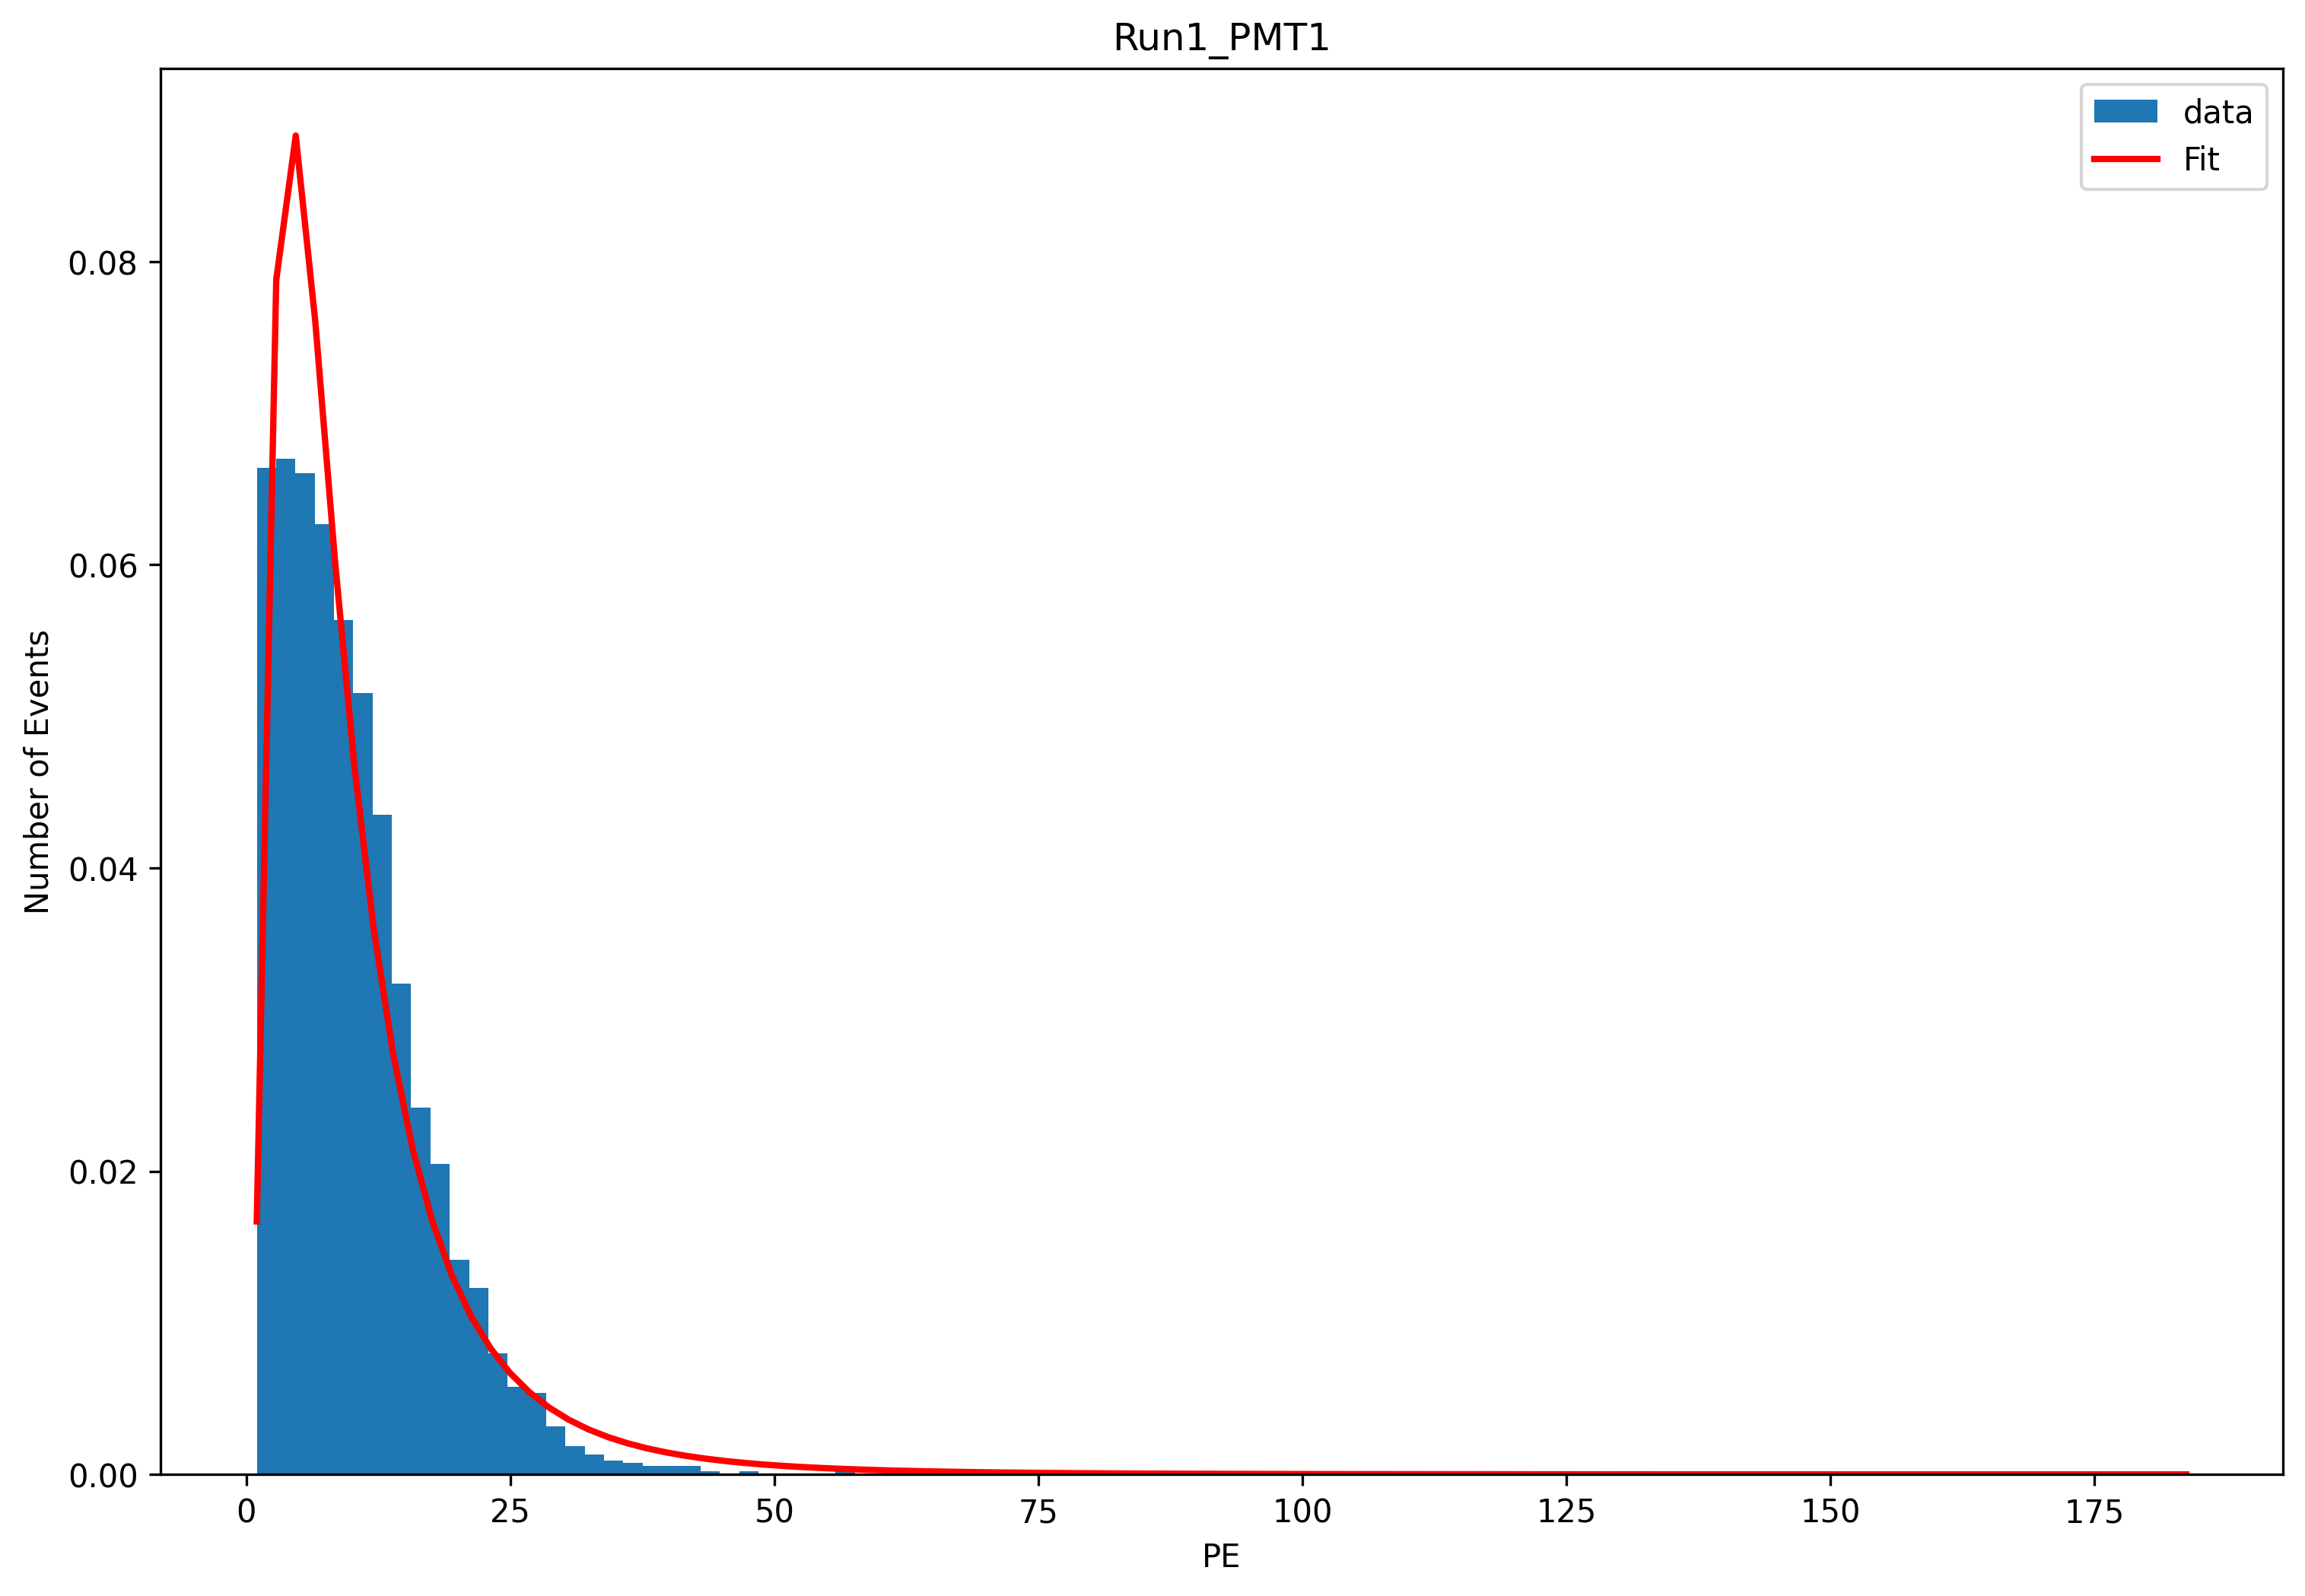

In [10]:
LogNormFit(Run1_Ch1AreaPEDrBrandt[1],"Run1_PMT1")

In [11]:
Run1_Ch2AreaPE=MultiAreaPE(Run1_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[1],p=False)

0.001139030644319146
3.6813617296657464


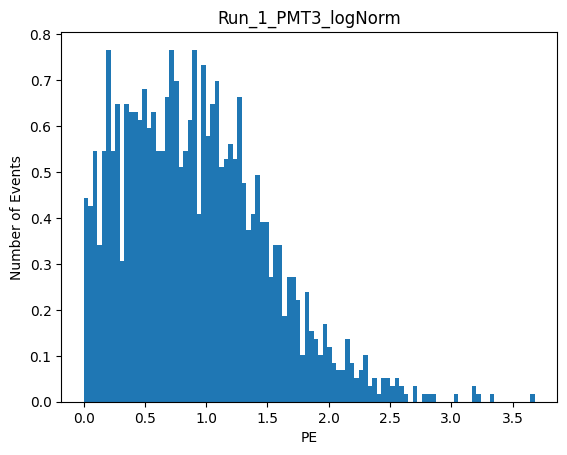

Area mean = 2.5146205306607543 stdev = 1.796122475297381


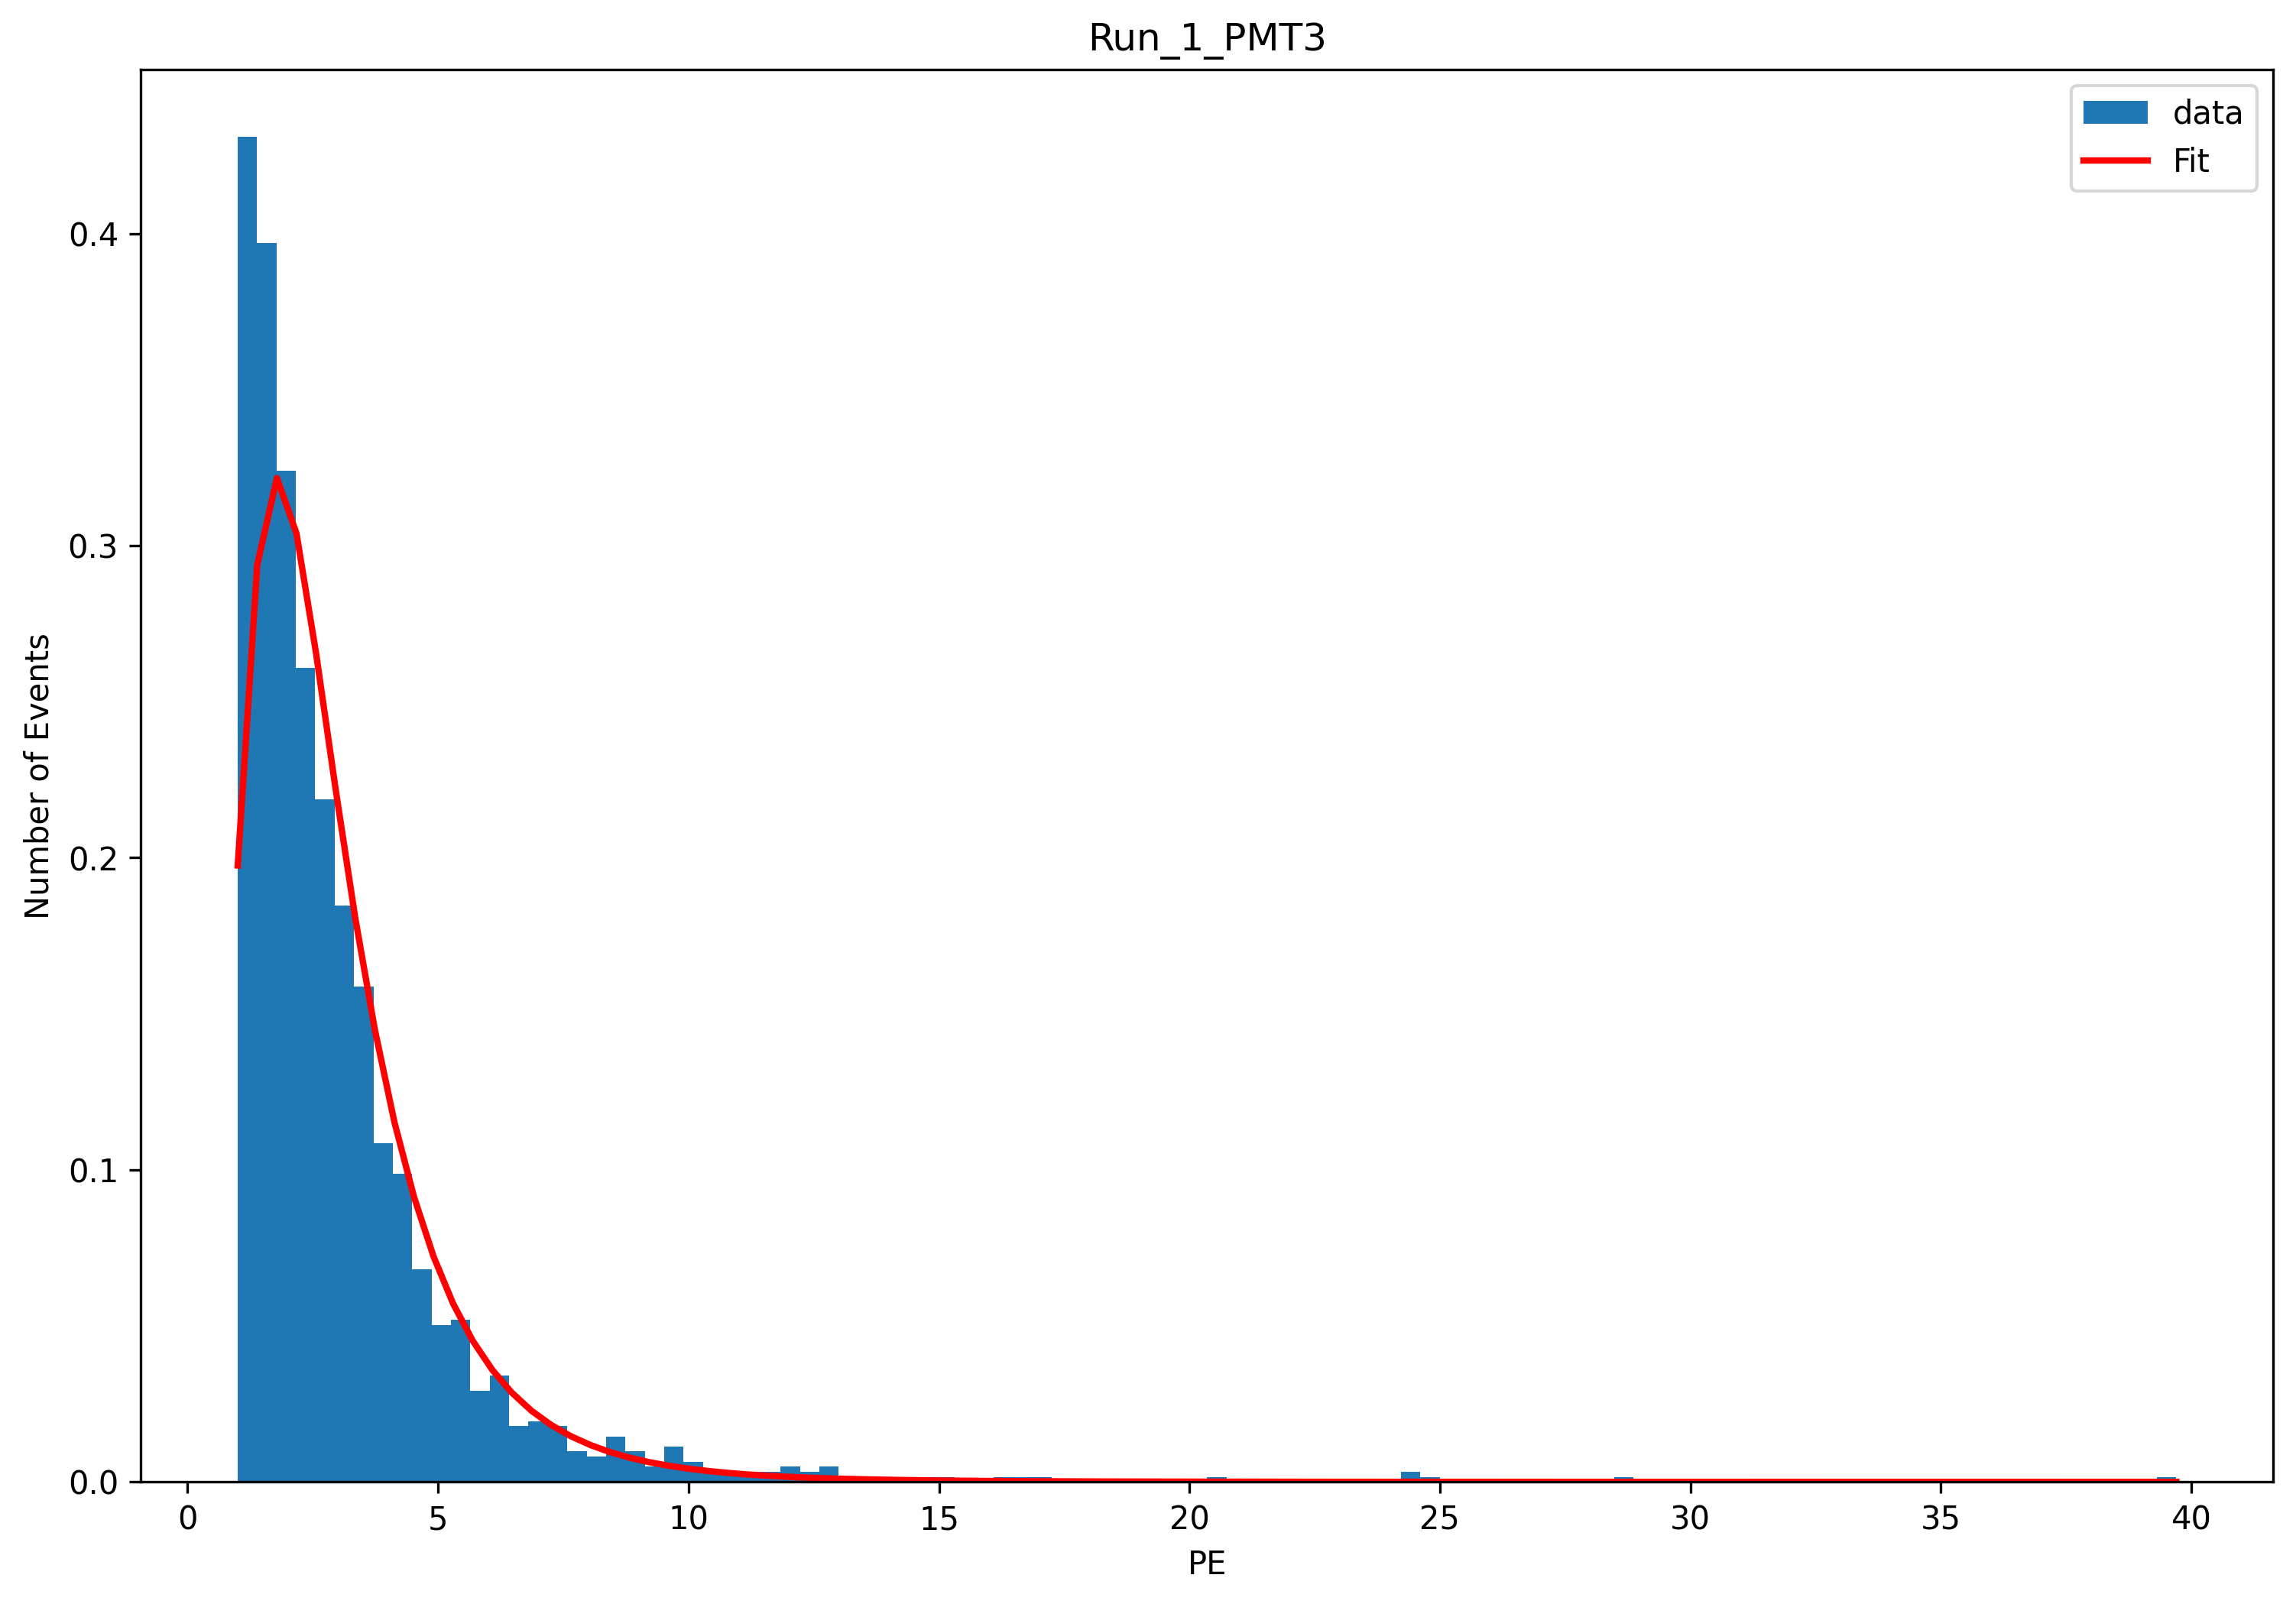

In [12]:

LogNormFit(Run1_Ch2AreaPE[1],"Run_1_PMT3")

In [13]:
###################### Run 2 ###################################
Run2_Ch1=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S1")[0]
Run2_Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S1")[1]

In [84]:

Run2QuickCh2=getValues(Run2_Ch1,5,nFiles=500,single=False,prnt=False)
xmin=min(Run2QuickCh2[2]["time"])
xmax=max(Run2QuickCh2[2]["time"])
print(xmin)
print(Run2QuickCh2)

Analyzing Following Files ---> /media/ilker/Ilker/CRAB/07.09.22/S1/C1s100480.csv
-7.620339e-05
{0: {'time': array([-7.623999e-05, -7.619999e-05, -7.615999e-05, ..., -2.627999e-05,
       -2.623999e-05, -2.619999e-05]), 'voltage': array([-1.66667e-04, -1.66667e-04, -6.25000e-05, ..., -3.75000e-04,
       -2.70833e-04, -1.66667e-04])}, 1: {'time': array([-7.620096e-05, -7.616096e-05, -7.612096e-05, ..., -2.628096e-05,
       -2.624096e-05, -2.620096e-05]), 'voltage': array([-0.000375  , -0.00027083, -0.00016667, ..., -0.00047917,
       -0.00027083, -0.00027083])}, 2: {'time': array([-7.620339e-05, -7.616339e-05, -7.612339e-05, ..., -2.624339e-05,
       -2.620339e-05, -2.616339e-05]), 'voltage': array([-1.66667e-04, -3.75000e-04, -2.70833e-04, ..., -1.66667e-04,
       -6.25000e-05, -2.70833e-04])}, 3: {'time': array([-7.623889e-05, -7.619889e-05, -7.615889e-05, ..., -2.627889e-05,
       -2.623889e-05, -2.619889e-05]), 'voltage': array([-6.25000e-05, -1.66667e-04, -6.25000e-05, ...,  4

 data = -0.0004249338174603175,value --> False


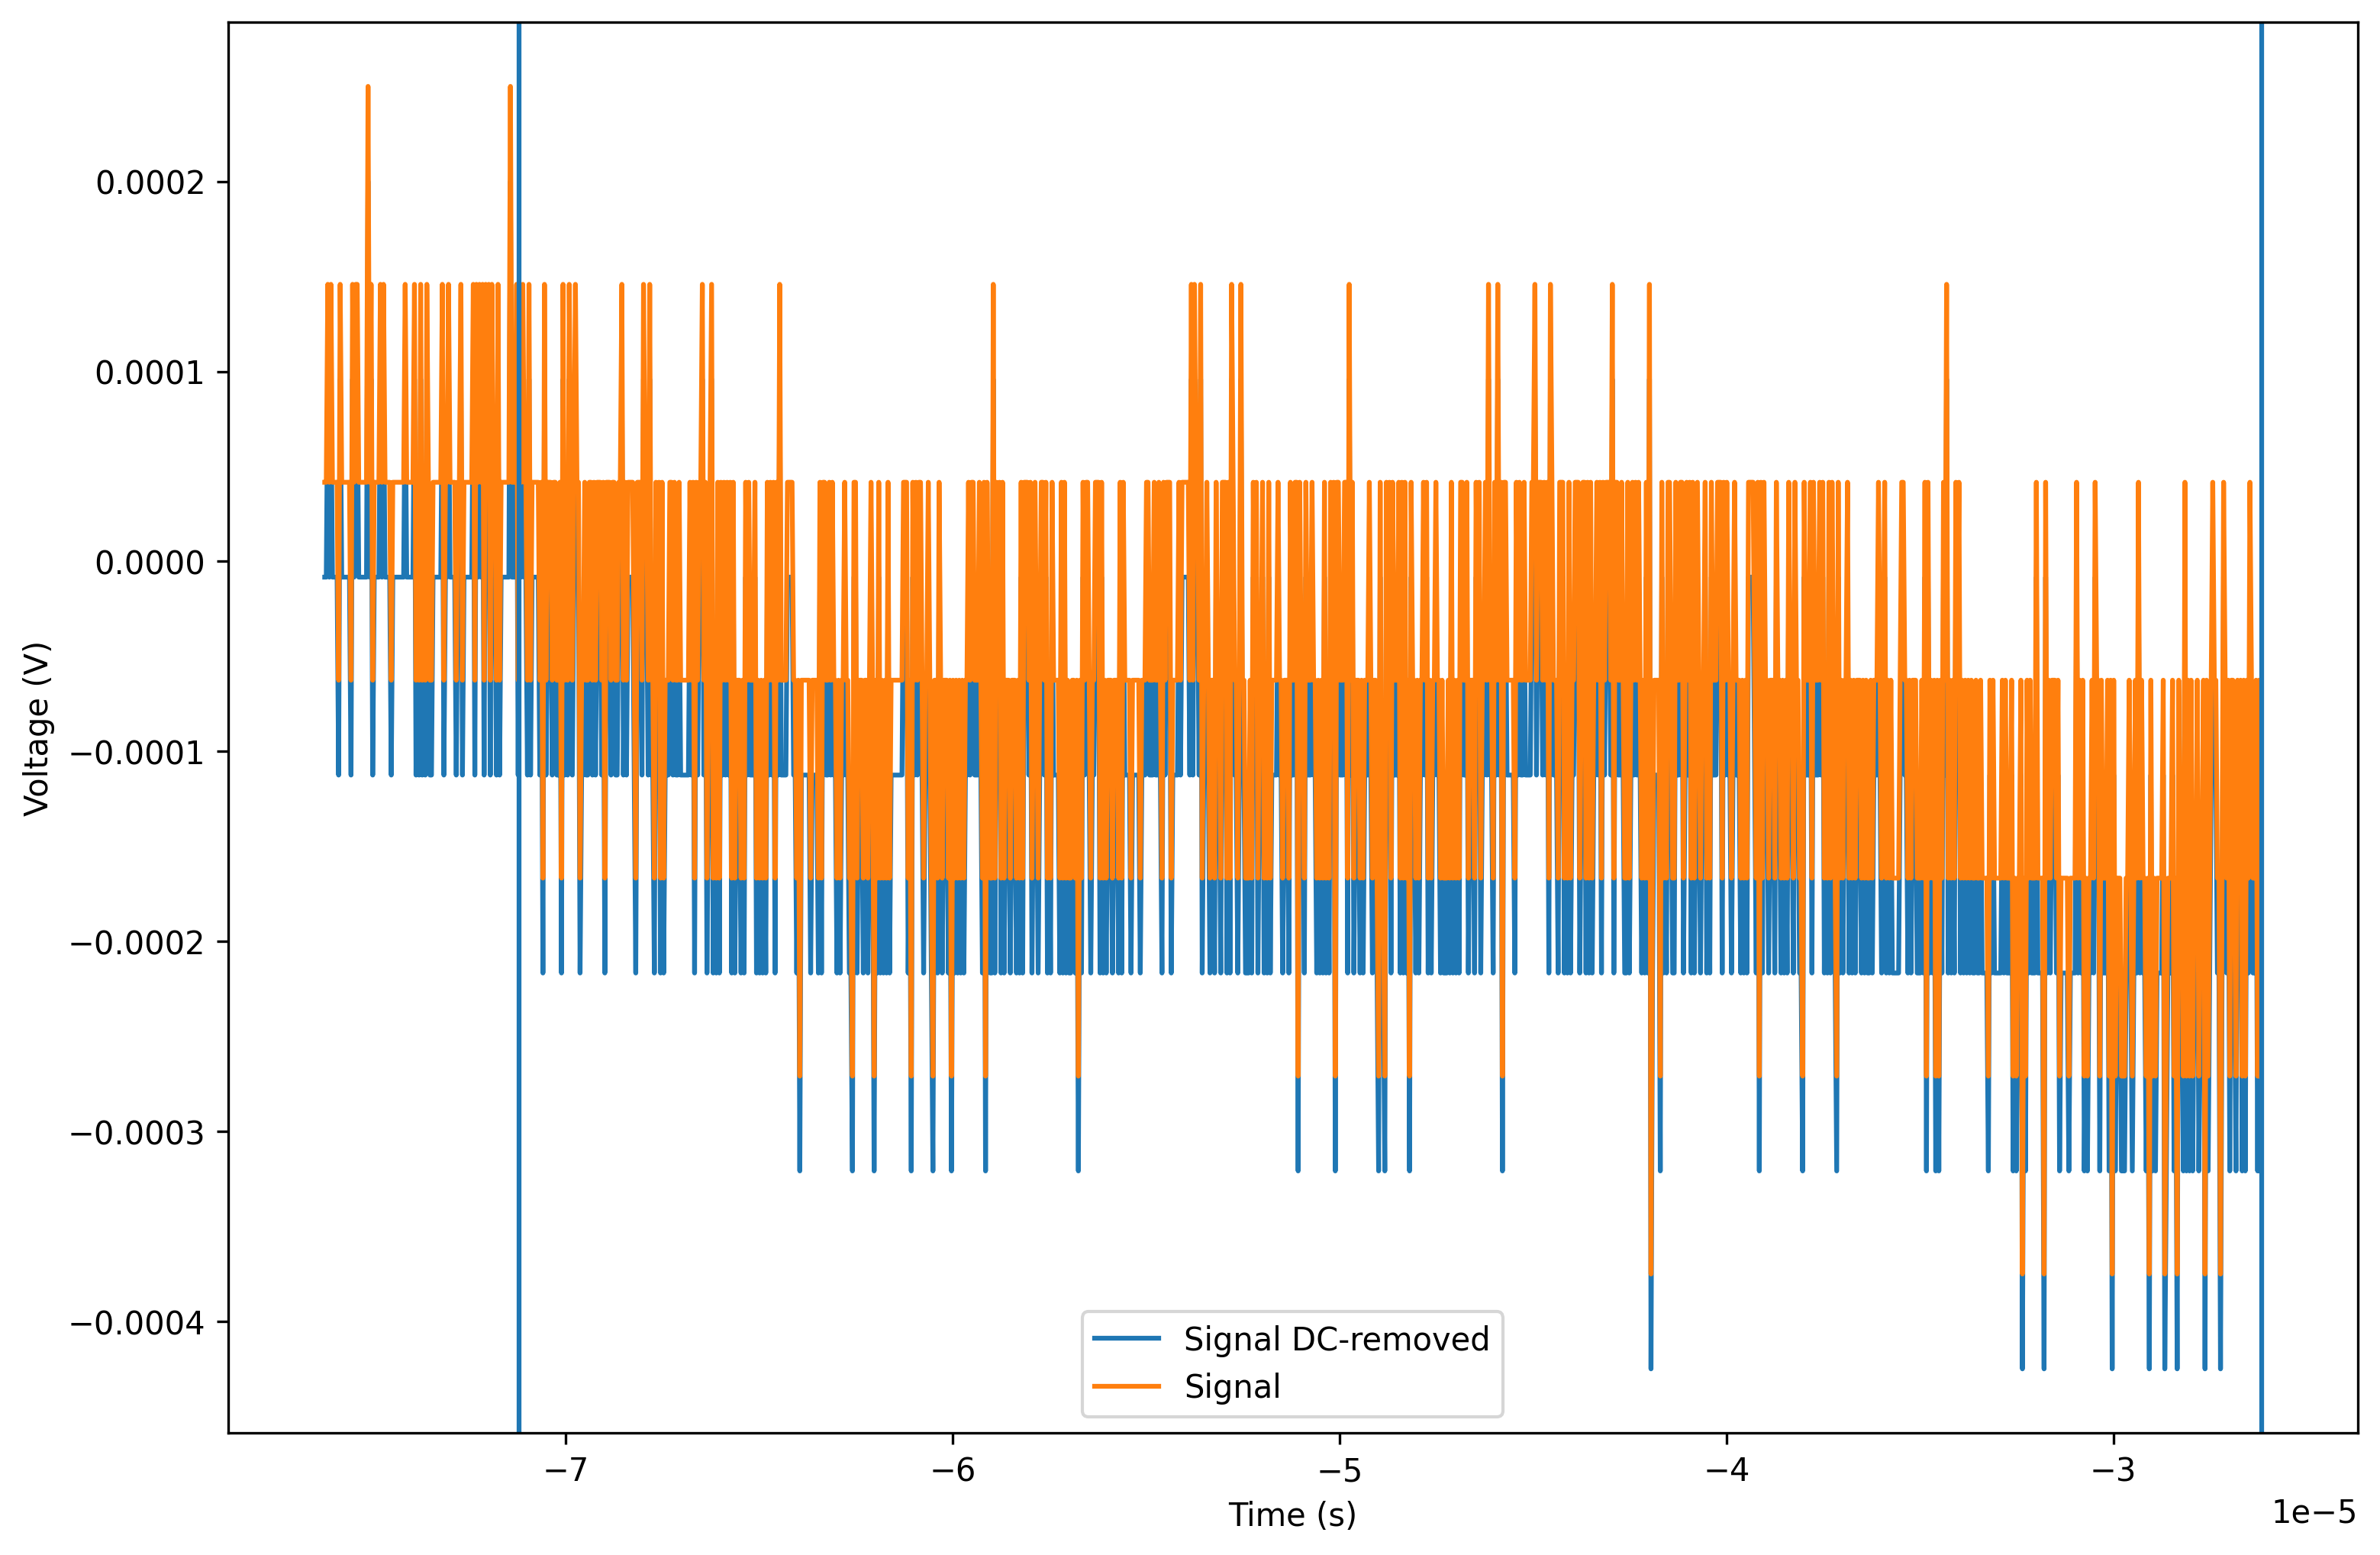

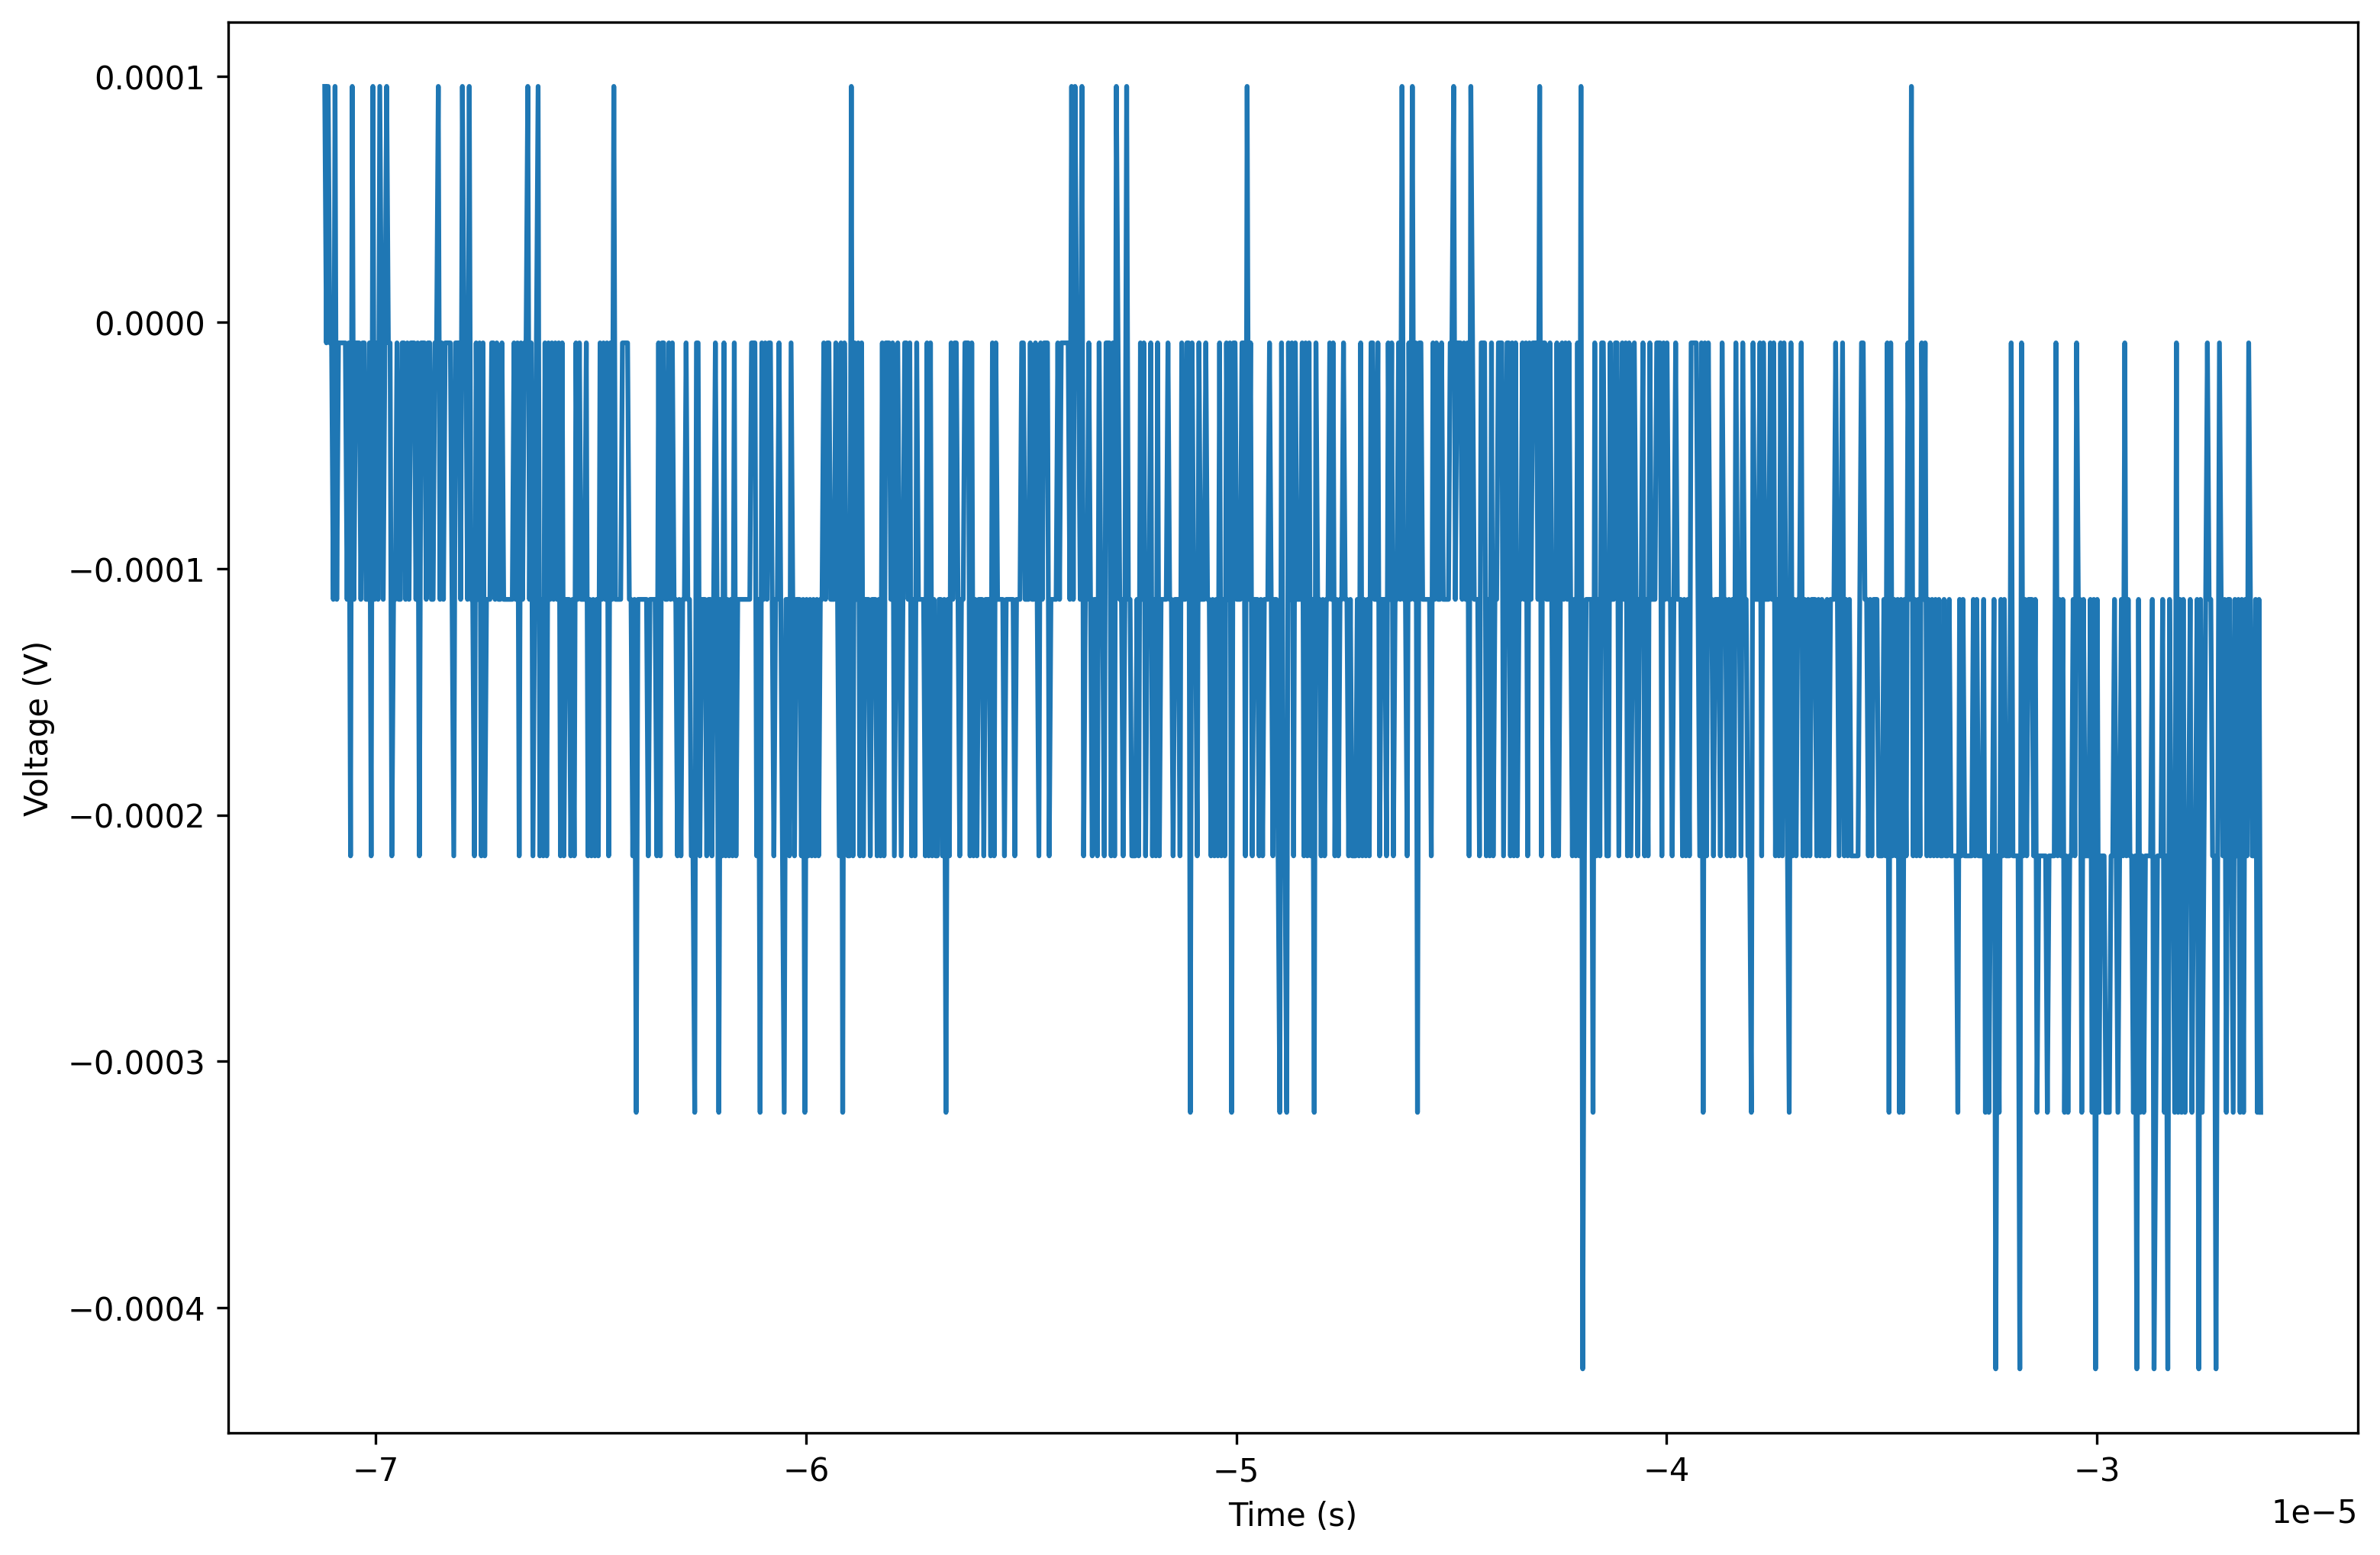

(5.472025089714289e-09, 173.220167449012)

In [93]:
getArea(Run2QuickCh2[4],xmin+0.5e-5,xmax,minpulse=-0.0004,gain=IlkersGains[0],p=True)

In [16]:
if(not(os.path.exists(Path+"Run2_Ch1_S1data.p"))): 
    Run2_Ch1data=getValues(Run2_Ch1,5,single=False,prnt=False)
    PickleITDump(Run2_Ch1data,Path+"Run2_Ch1_S1data.p")
else:
    Run2_Ch1data=PickleITRead(Path+"Run2_Ch1_S1data.p")
    
if(not(os.path.exists(Path+"Run2_Ch2_S1data.p"))):
    Run2_Ch2data=getValues(Run2_Ch2,5,single=False,prnt=False)
    PickleITDump(Run2_Ch2data,Path+"Run2_Ch2_S1data.p")
else:
    Run2_Ch2data=PickleITRead(Path+"Run2_Ch2_S1data.p")

In [17]:
### PMT1 ###
Run2_Ch1AreaPEIlker=MultiAreaPE(Run2_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=IlkersGains[0],p=False)
Run2_Ch1AreaPENick=MultiAreaPE(Run2_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=NicksGains[0],p=False)
Run2_Ch1AreaPEDrBrandt=MultiAreaPE(Run2_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)

### PMT3 ####
Run2_Ch2AreaPEIlker=MultiAreaPE(Run2_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=IlkersGains[0],p=False)
Run2_Ch2AreaPENick=MultiAreaPE(Run2_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=NicksGains[0],p=False)
Run2_Ch2AreaPEDrBrandt=MultiAreaPE(Run2_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)



Day2_PMT1=MultiAreaPE(Run2_Ch1data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=1,p=False)
Day2_PMT3=MultiAreaPE(Run2_Ch2data,xmin+0.2e-5,xmax,minpulse=-0.0004,g=1,p=False)

In [18]:
### S1 Signal File
values={"Day1_Ch1Area_PMT1":Day1_PMT1,
        "Day1_Ch2Area_PMT3":Day1_PMT3,
        "Day2_Ch1Area_PMT1":Day2_PMT1,
        "Day2_Ch2Area_PMT3":Day2_PMT3}
PickleITDump(values,"S1Areav2.p")


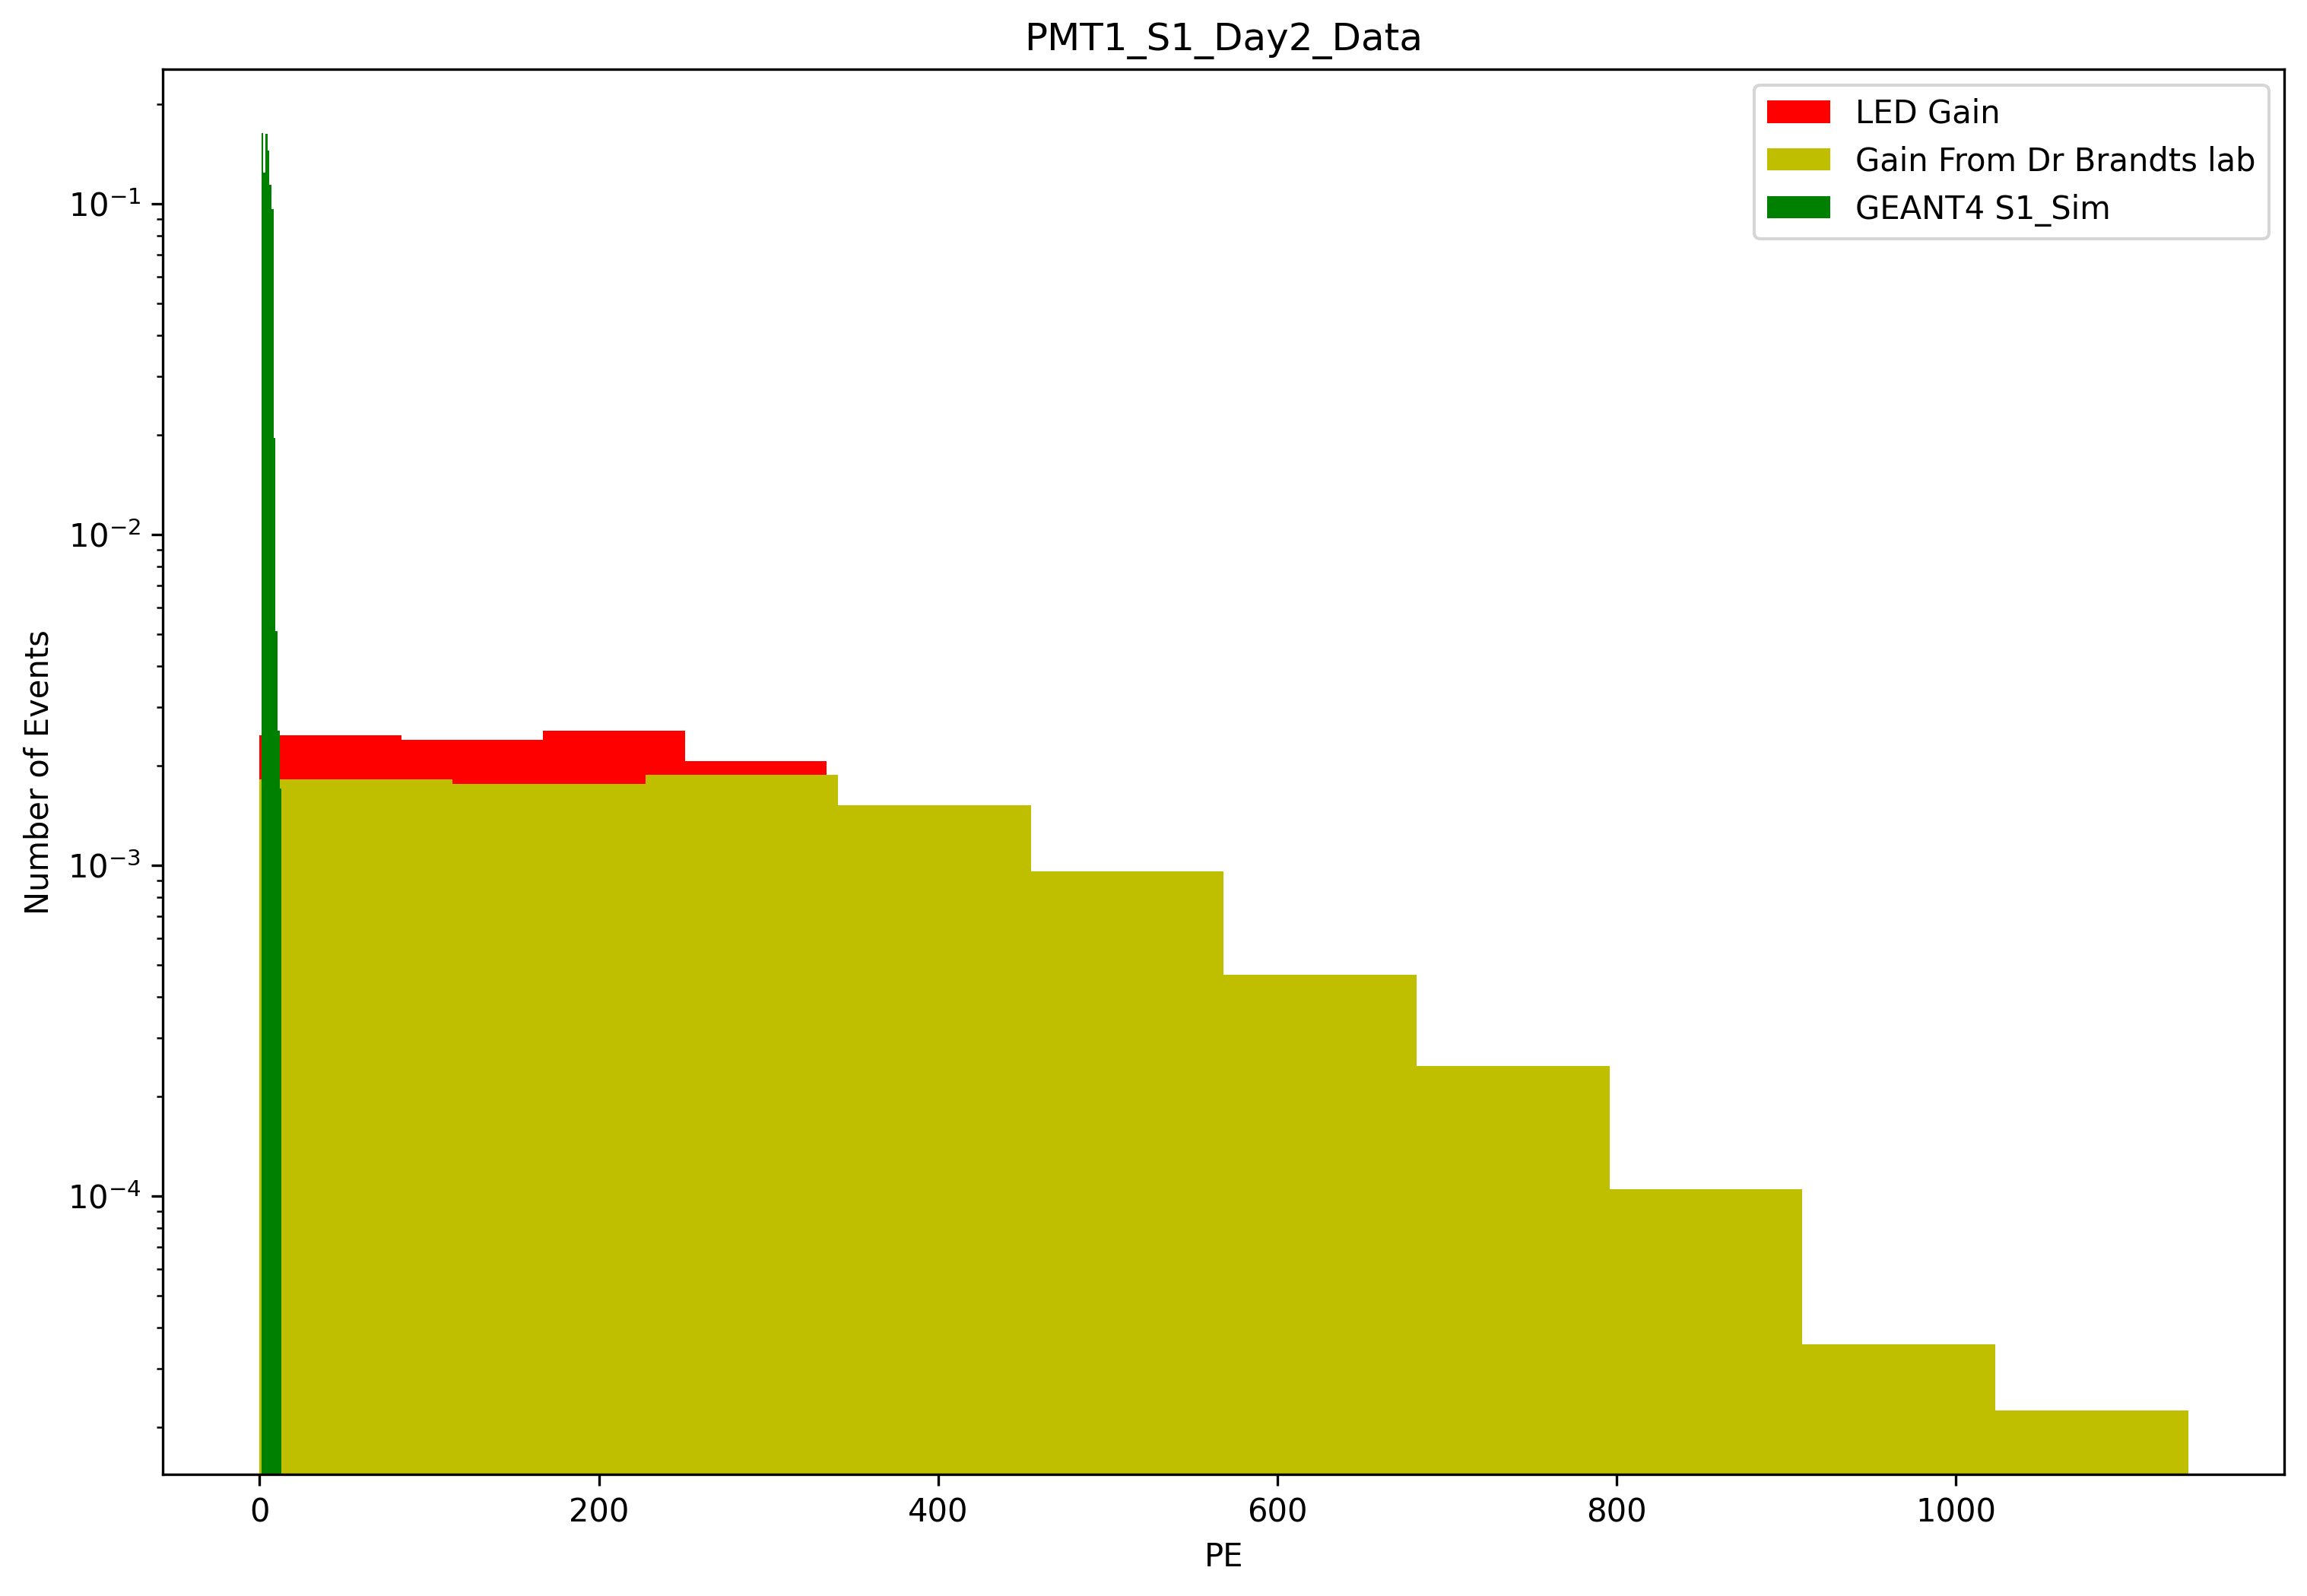

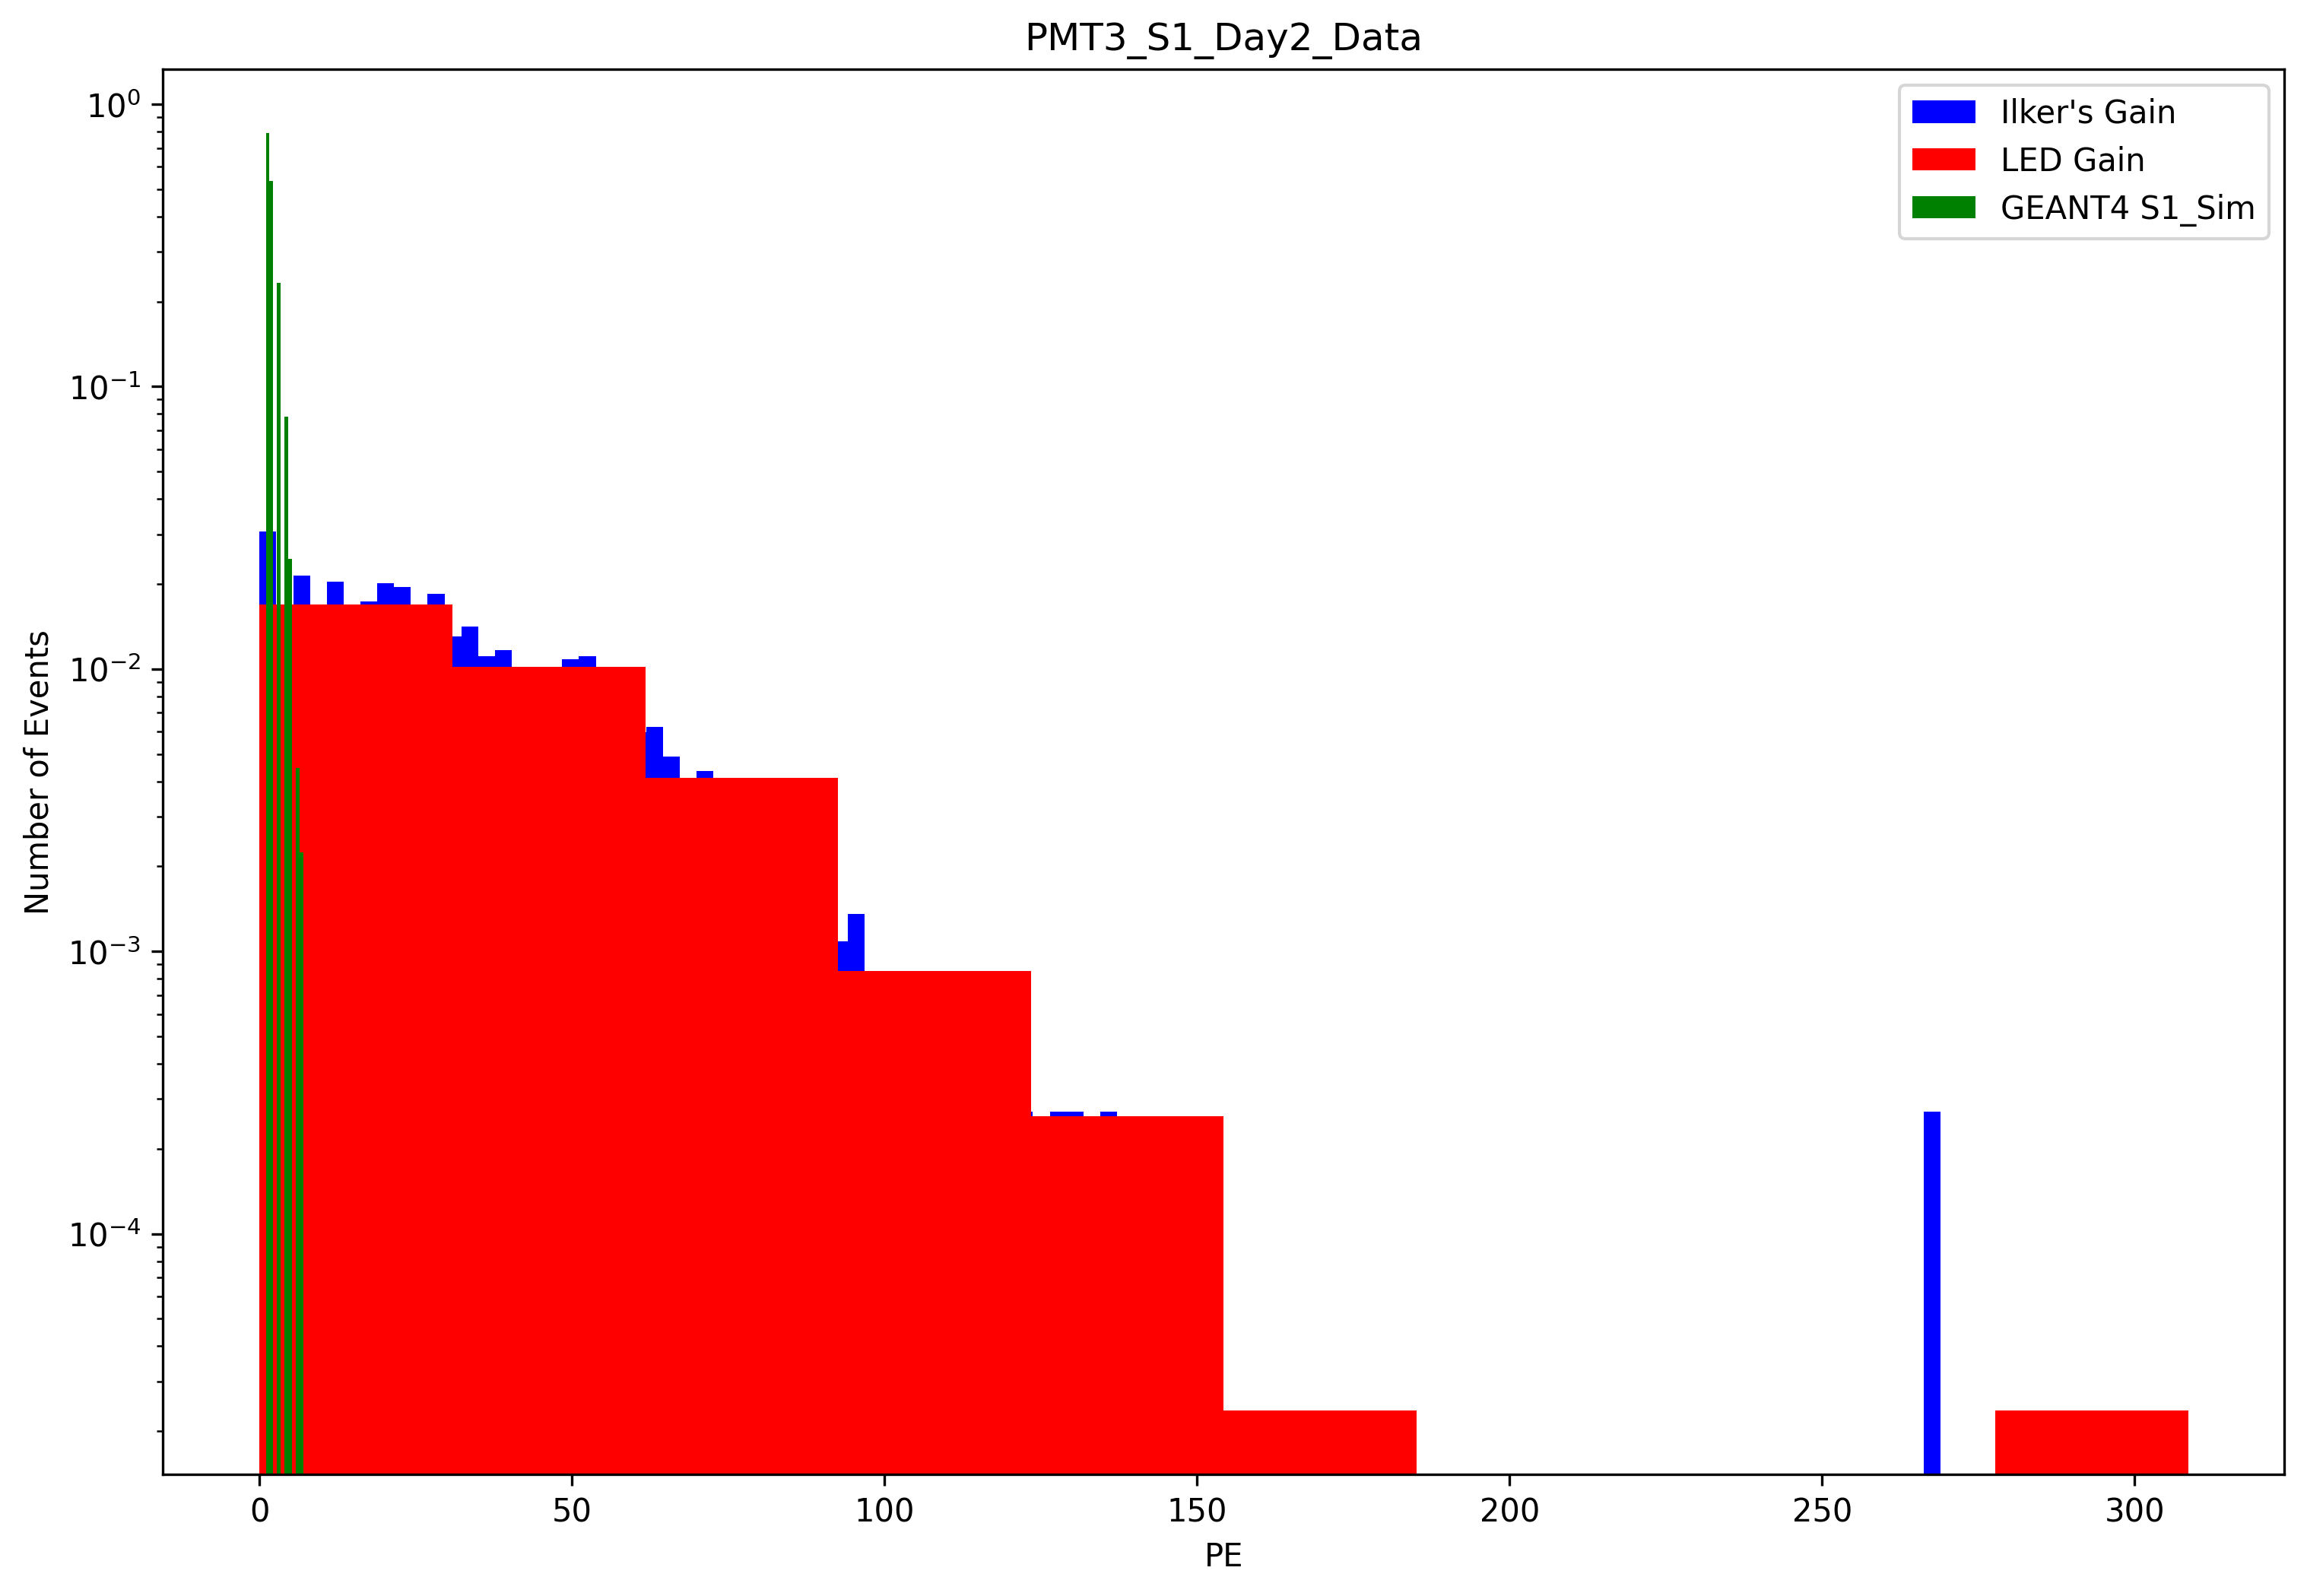

In [19]:
############ S1 Comp #######################
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1_S1_Day2_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(Run2_Ch1AreaPEIlker[1],bins=100,density=True,stacked=True,label="Ilker's Gain",color="b")
plt.hist(Run2_Ch1AreaPENick[1],bins=10,density=True,stacked=True,label="LED Gain",color="r")
plt.hist(Run2_Ch1AreaPEDrBrandt[1],bins=10,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
plt.hist(S1["S2_PHOTOCATHODE"],bins=10,density=True,stacked=True,label="GEANT4 S1_Sim",color="g")

plt.semilogy()


plt.legend()
plt.show()




############ S1 Comp #######################
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3_S1_Day2_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Run2_Ch2AreaPEIlker[1],bins=100,density=True,stacked=True,label="Ilker's Gain",color="b")
plt.hist(Run2_Ch2AreaPENick[1],bins=10,density=True,stacked=True,label="LED Gain",color="r")
#plt.hist(Run2_Ch2AreaPEDrBrandt[1],bins=10,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
plt.hist(S1["S1_PHOTOCATHODE"],bins=10,density=True,stacked=True,label="GEANT4 S1_Sim",color="g")

plt.semilogy()

plt.legend()

In [20]:
Run2_Ch1AreaPE=MultiAreaPE(Run2_Ch1data,-4e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)



0.09519987614144752
6.718222065782826


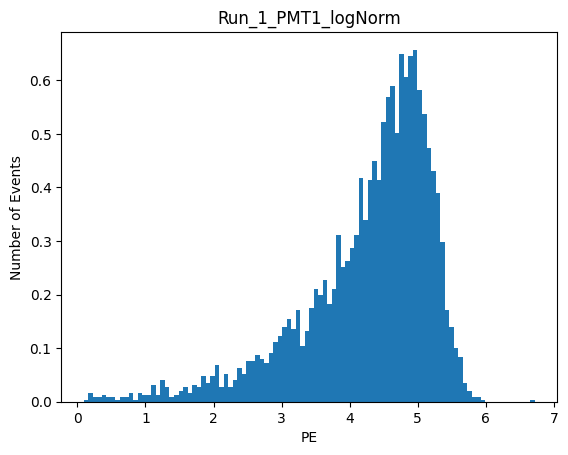

Area mean = 71.9015947670697 stdev = 2.592390445708472


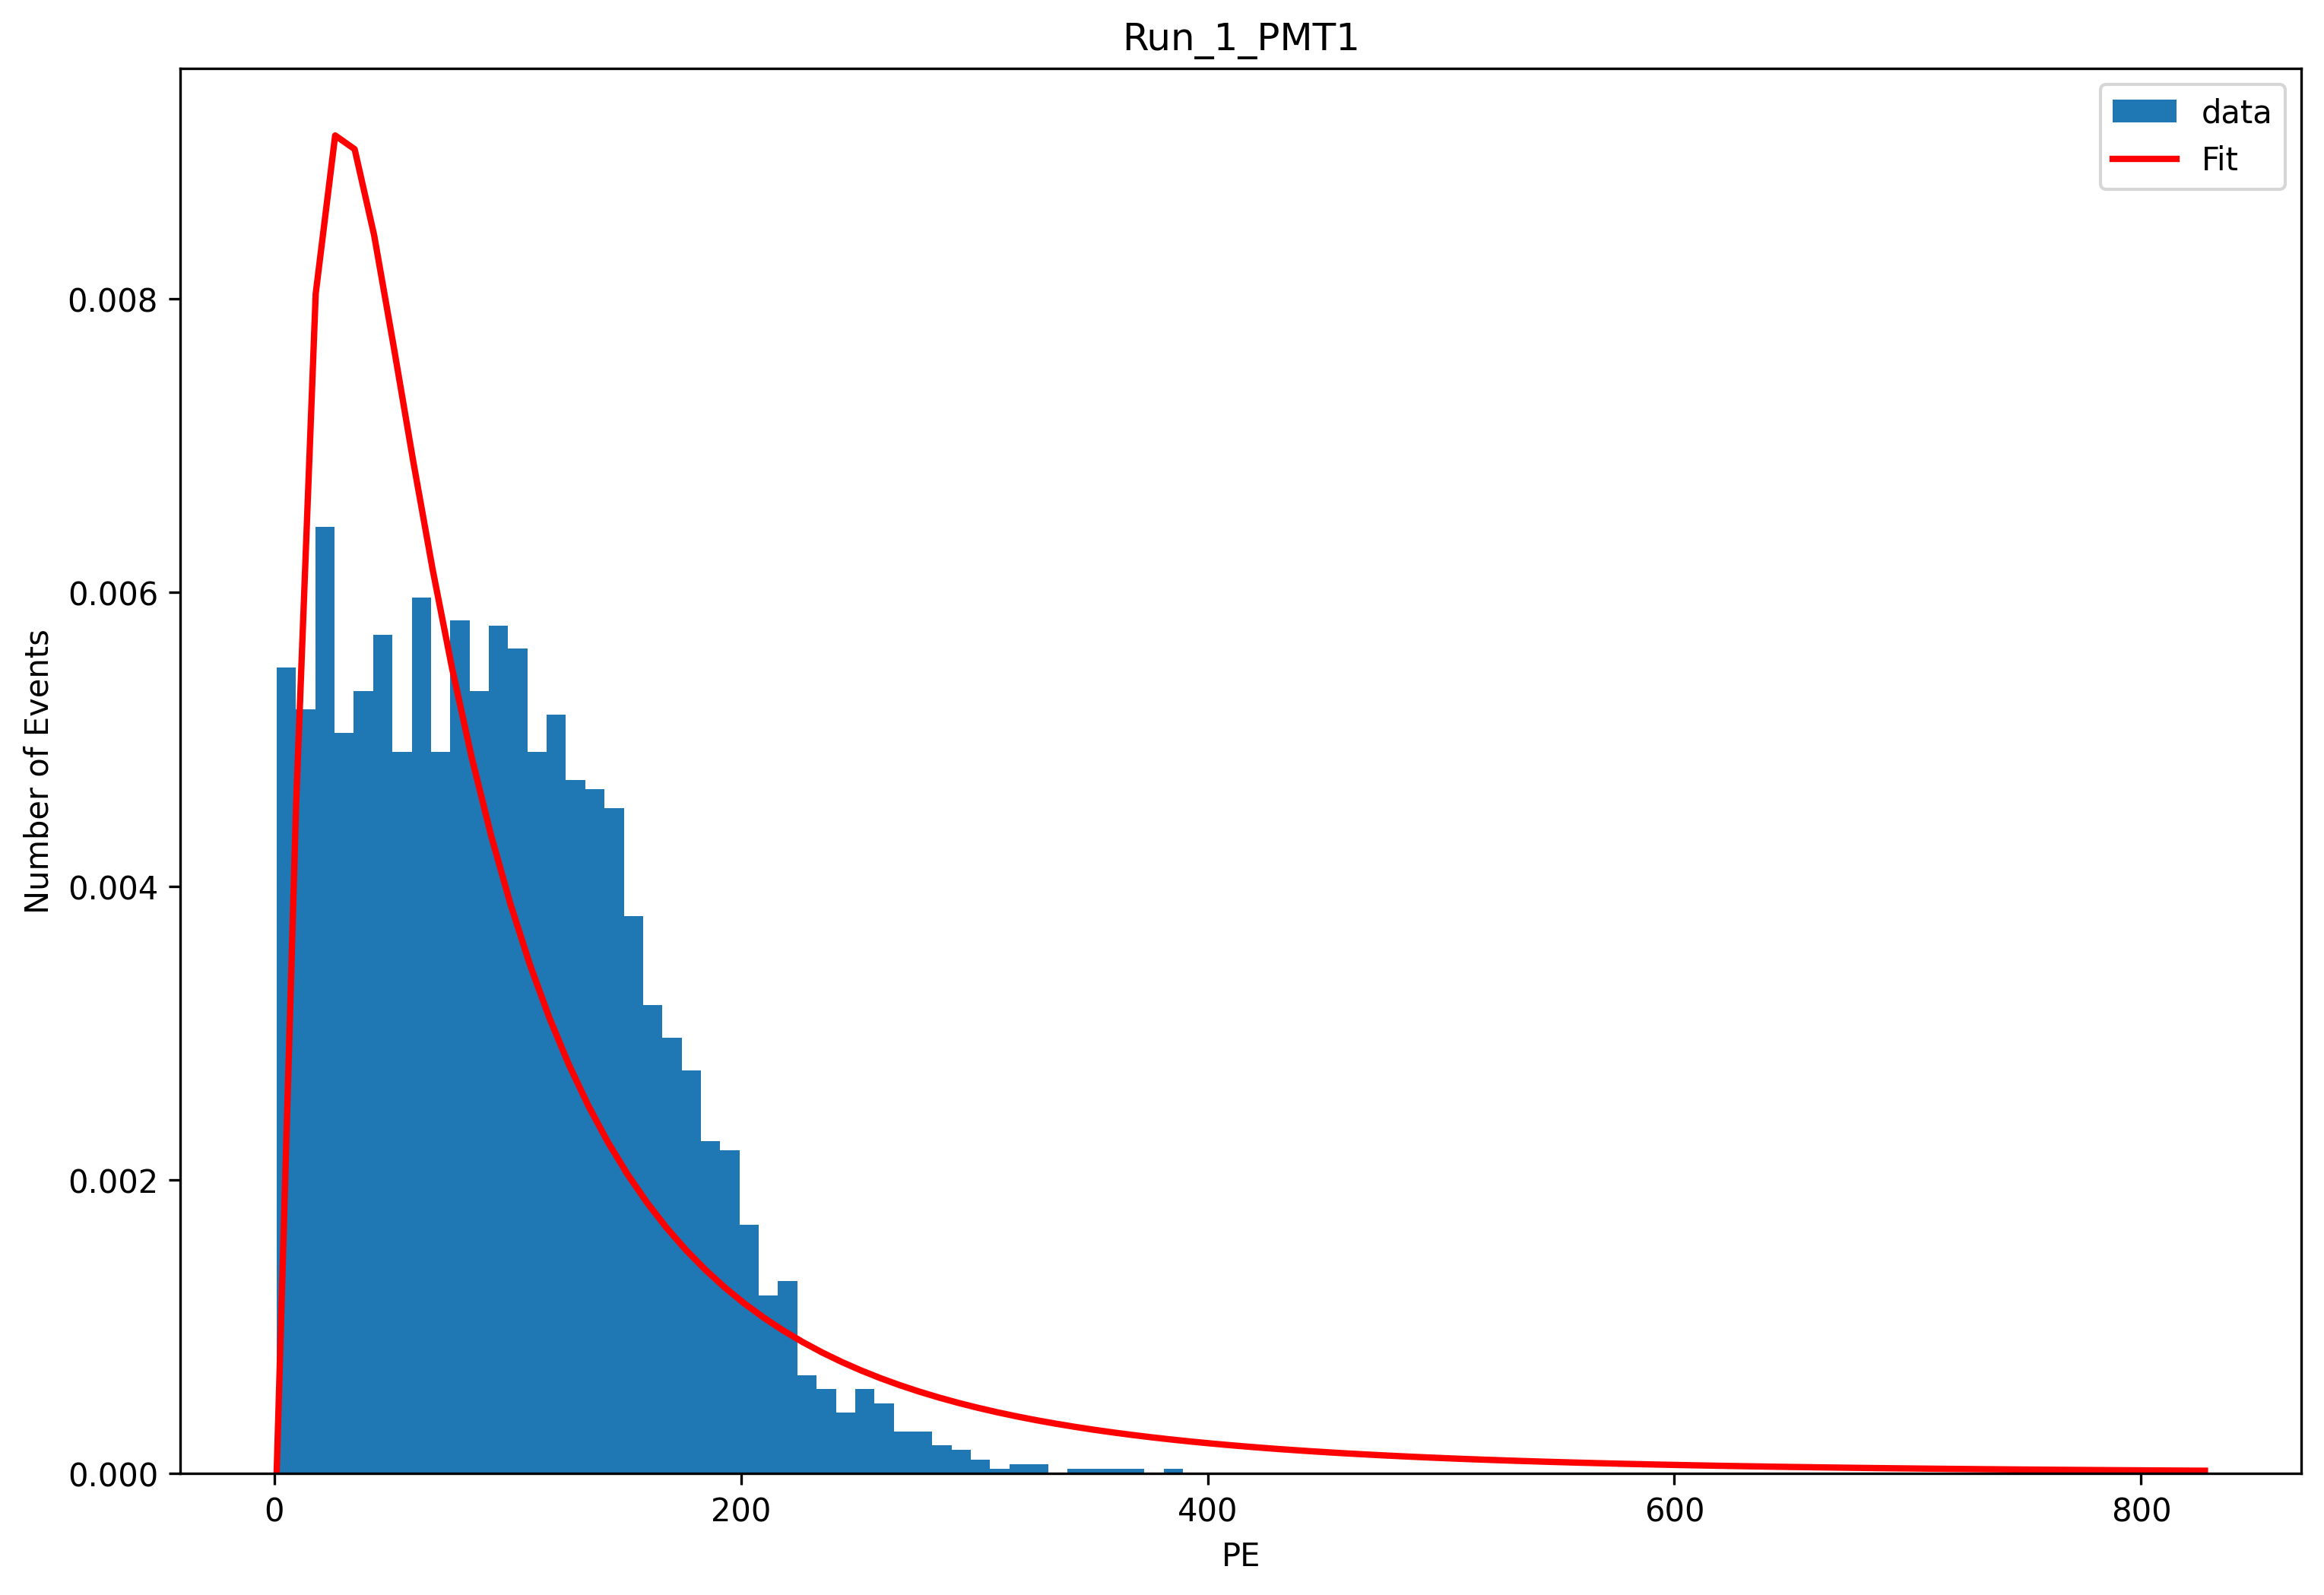

In [21]:
LogNormFit(Run2_Ch1AreaPE[1],"Run_1_PMT1")


0.024416968796337327
4.864399326584118


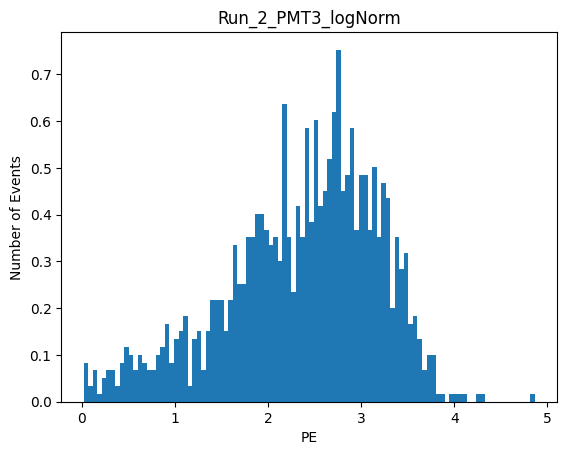

Area mean = 10.654782985598008 stdev = 2.2749231927776523


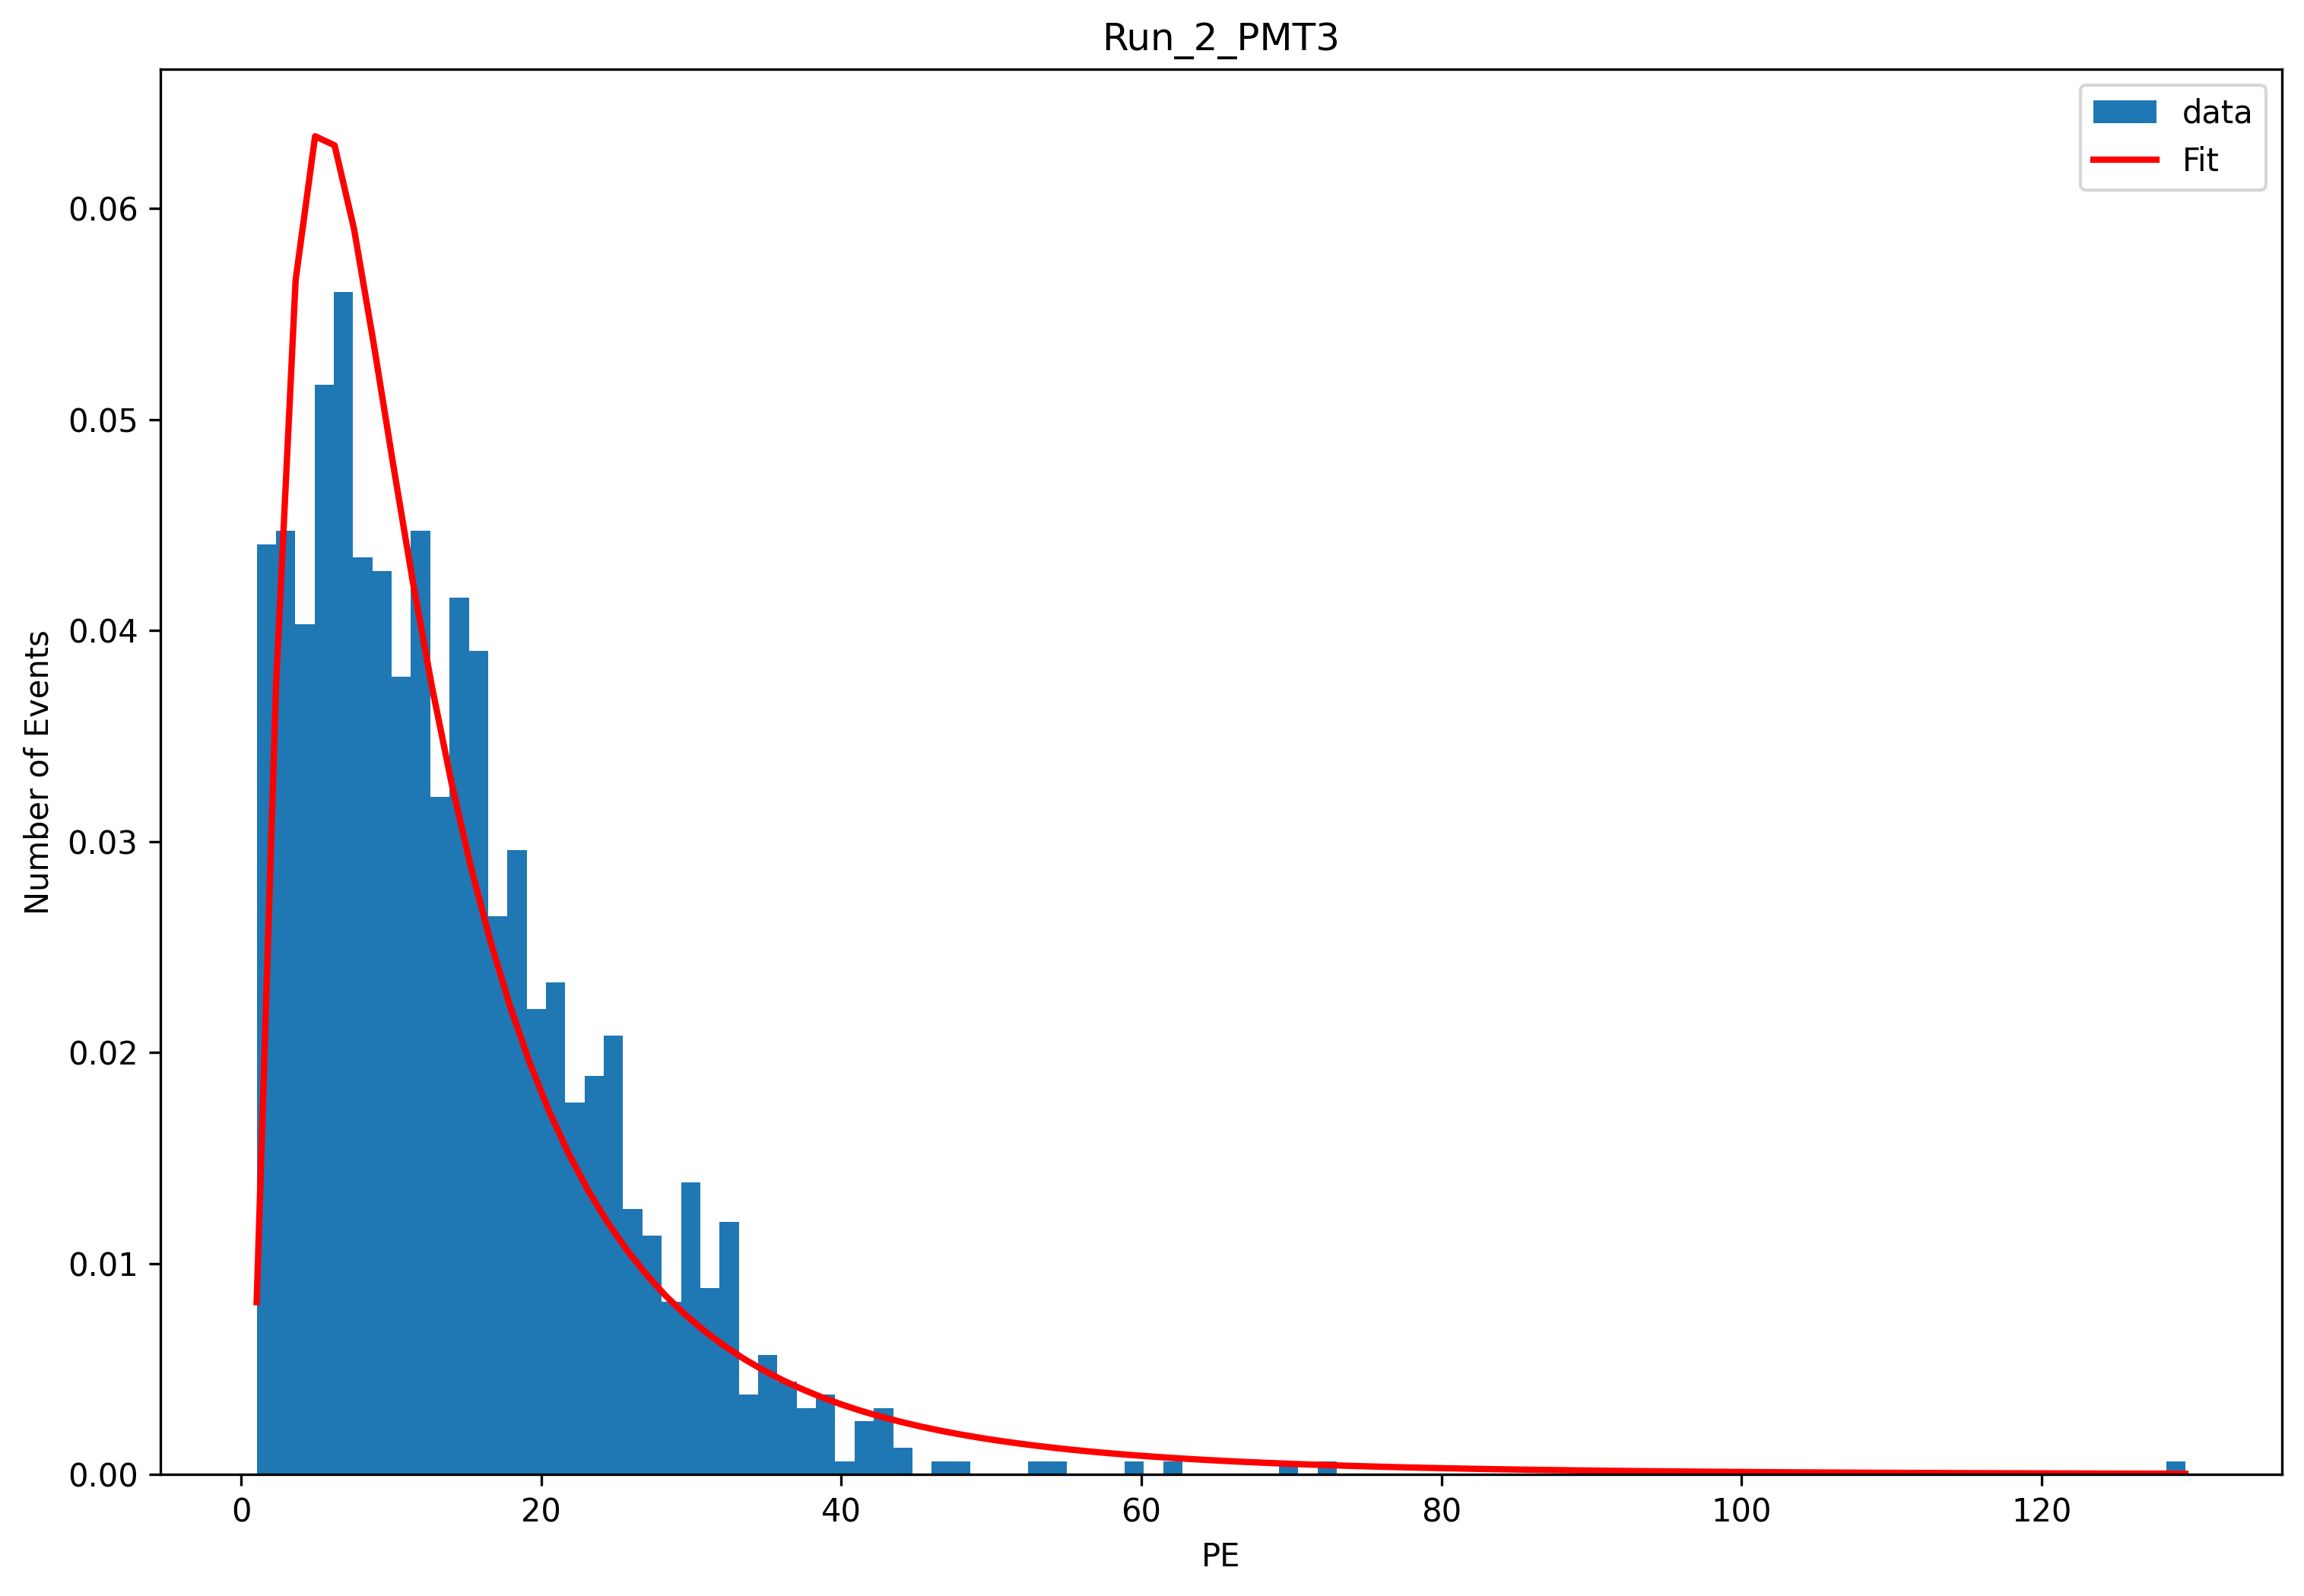

In [22]:

Run2_Ch2AreaPE=MultiAreaPE(Run2_Ch2data,-4e-5,xmax,minpulse=-0.0004,g=DrBrandtGains[0],p=False)

LogNormFit(Run2_Ch2AreaPE[1],"Run_2_PMT3")